## Import modules

In [1]:
import math
import random
import numpy as np
import pandas as pd

from pylab import rcParams
from scipy.io import loadmat

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.ensemble import IsolationForest

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay

# Make datasets

- Ref

https://scikit-learn.org/stable/auto_examples/ensemble/plot_isolation_forest.html#sphx-glr-auto-examples-ensemble-plot-isolation-forest-py

- Ïù¥ÏÉÅÏπò ÌÉêÏßÄÎ•º ÏúÑÌï¥ Îã§ÏàòÏùò Ï†ïÏÉÅ Îç∞Ïù¥ÌÑ∞ÏôÄ, ÏÜåÏàòÏùò Ïù¥ÏÉÅÏπòÎ•º ÏÉùÏÑ±Ìï©ÎãàÎã§.

In [2]:
rng = np.random.RandomState(42)

# Generate train data
X = 0.3 * rng.randn(1000, 2)
X_normal1 = np.r_[X + 2, X - 2]
X_normal1 = pd.DataFrame(X_normal1, columns=['x1', 'x2'])
# Generate some regular novel observations
X = 0.3 * rng.randn(200, 2)
X_normal2 = np.r_[X + 2, X - 2]
X_normal2 = pd.DataFrame(X_normal2, columns=['x1', 'x2'])
# Generate some abnormal novel observations
X_outliers = rng.uniform(low=-4, high=4, size=(50, 2))  # Ïù¥ÏÉÅÏπò Í∞úÏàò Ï°∞Ï†à
X_outliers = pd.DataFrame(X_outliers, columns=['x1', 'x2'])

In [3]:
# Putting them together
X = pd.concat([X_normal1, X_normal2, X_outliers], axis=0, ignore_index=True)

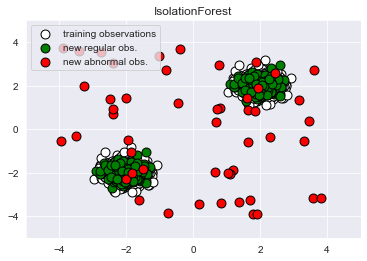

In [4]:
plt.title("IsolationForest")
plt.rcParams['figure.figsize'] = [10, 10]
p1 = plt.scatter(X_normal1.x1, X_normal1.x2, c='white', s=20*4, edgecolor='k', label='training observations')
p2 = plt.scatter(X_normal2.x1, X_normal2.x2, c='green', s=20*4, edgecolor='k', label='new regular obs.')
p3 = plt.scatter(X_outliers.x1, X_outliers.x2, c='red', s=20*4, edgecolor='k', label='new abnormal obs.')

plt.axis("tight")
plt.xlim((-5, 5))
plt.ylim((-5, 5))

plt.legend(loc='best')

plt.show()

- Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ Î≥¥Î©¥ Îã§ÏùåÍ≥º Í∞ôÏù¥ ÌïòÏñÄÏÉâÏùò train Ï†ïÏÉÅ Îç∞Ïù¥ÌÑ∞, Ï¥àÎ°ùÏÉâÏùò ÏÉàÎ°≠Í≤å Îì§Ïñ¥Í∞à Ï†ïÏÉÅ Îç∞Ïù¥ÌÑ∞, ÎßàÏßÄÎßâÏúºÎ°ú Îπ®Í∞ÑÏÉâÏùò Ïù¥ÏÉÅÏπò Îç∞Ïù¥ÌÑ∞Í∞Ä ÏûàÏäµÎãàÎã§.

In [5]:
# Function to produce a heatmap of the scores
pts = np.linspace(-5, 5, 250)
space = np.array(np.meshgrid(pts, pts)).reshape((2, -1)).T
space_index = pd.MultiIndex.from_arrays([space[:, 0], space[:, 1]])


def plot_space(Z, space_index, X):
    df = pd.DataFrame({"z": Z}, index=space_index)
    df = df.unstack()
    df = df[df.columns.values[::-1]]
    plt.imshow(df, extent=[-5, 5, -5, 5], cmap='hot_r')
    plt.scatter(x=X['x1'], y=X['x2'], alpha=.15, c='navy')

# Isolation Forest

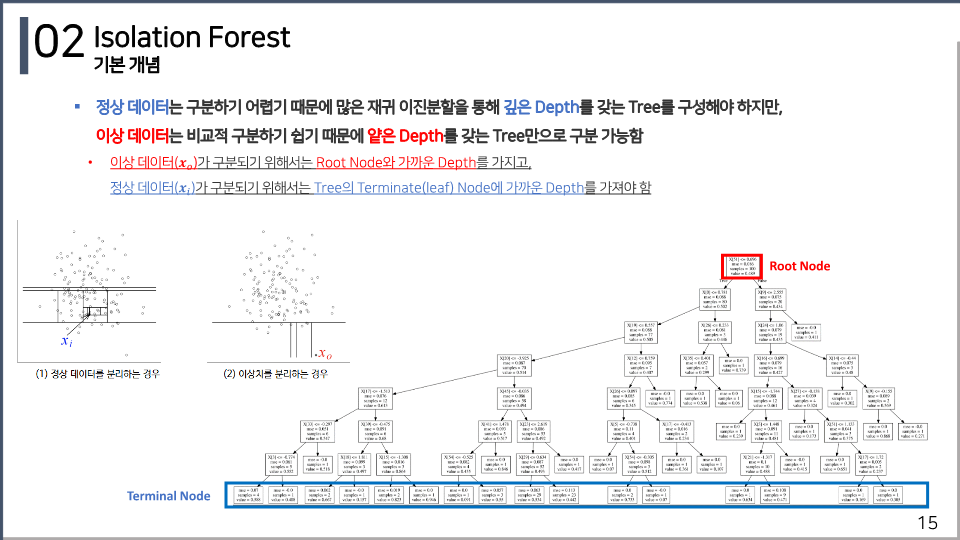

## Hyperparameter (n_estimators, max_samples, contamination, max_features)

- Î≥∏ ÏàúÏÑúÏóêÏÑúÎäî sklearnÏóêÏÑú Ï†úÍ≥µÌïòÎäî IsolationForest ÎùºÏù¥Î∏åÎü¨Î¶¨Î•º ÏÇ¨Ïö©ÌïòÏó¨ ÌååÎùºÎØ∏ÌÑ∞ Î≥ÄÌôîÏóê Îî∞Î•∏ Î™®Îç∏Ïùò Î≥ÄÌôîÎ•º Î≥¥Ïó¨Ï£ºÍ≥†Ïûê Ìï©ÎãàÎã§.
- ÏïÑÎûòÎäî ÌååÎùºÎØ∏ÌÑ∞Ïóê ÎåÄÌïú ÏÑ§Î™ÖÏûÖÎãàÎã§.

    n_estimators: int, default=100
     - ÏïôÏÉÅÎ∏îÏóê ÌôúÏö©Ìï† Î∂ÑÎ•òÍ∏∞(iTree)Ïùò Ïàò
         - ÎßéÏùÑ ÏàòÎ°ù Ï¢ãÏùÄ ÏÑ±Îä•ÏùÑ Í∏∞ÎåÄÌï† Ïàò ÏûàÏßÄÎßå, ÎßéÏùÄ ÌïôÏäµ ÏàòÌñâ ÏãúÍ∞ÑÏù¥ ÏÜåÏöî

    max_samples: ‚Äúauto‚Äù, int or float, default=‚Äùauto‚Äù
     - Î∂ÑÎ•òÍ∏∞(iTree)Î•º ÌïôÏäµÌïòÍ∏∞ ÏúÑÌï¥ Îç∞Ïù¥ÌÑ∞ÏÖãÏóêÏÑú Ï∂îÏ∂úÌï† ÏÉòÌîåÏùò Ïàò
     - ÏßÅÏ†ë Í∞úÏàòÎ•º ÏÑ§Ï†ïÌïòÍ±∞ÎÇò, Îç∞Ïù¥ÌÑ∞ÏÖãÏóêÏÑú ÎπÑÏú®ÏùÑ ÏÑ§Ï†ïÌï† Ïàò ÏûàÏùå
         - 'auto'Îäî min(256, n_samples)ÏóêÏÑú ÏÑ†ÌÉù

    contamination: ‚Äòauto‚Äô or float, default=‚Äôauto‚Äô
     - Îç∞Ïù¥ÌÑ∞ÏÖãÏóêÏÑú Ïù¥ÏÉÅÏπòÏùò ÎπÑÏú®, Ïù¥ÏÉÅÏπòÎ°ú ÌåêÎã®ÌïòÍ∏∞ ÏúÑÌïú scoreÏùò thresholdÎ•º Ï†ïÏùò
         - 'auto'Îäî ÎÖºÎ¨∏Ïùò Í∞íÏùÑ Îî∞Î•¥Í≥†, floatÏùò Í∞íÏùÄ (0, 0.5] ÏÇ¨Ïù¥Ïóê Ï°¥Ïû¨Ìï¥ÏïºÌï®

    max_features:int or float, default=1.0
     - Í∞Å Î∂ÑÎ•òÍ∏∞(iTree)Î•º ÌïôÏäµÌï† Îïå ÏÇ¨Ïö©Ìï† featureÏùò Í∞úÏàò

### n_estimator (5, 10, 20, 50, 100, 200, 250, 500, 1000)

In [6]:
n_estimators_list = [5, 10, 20, 50, 100, 200, 250, 500, 1000]  # default:100

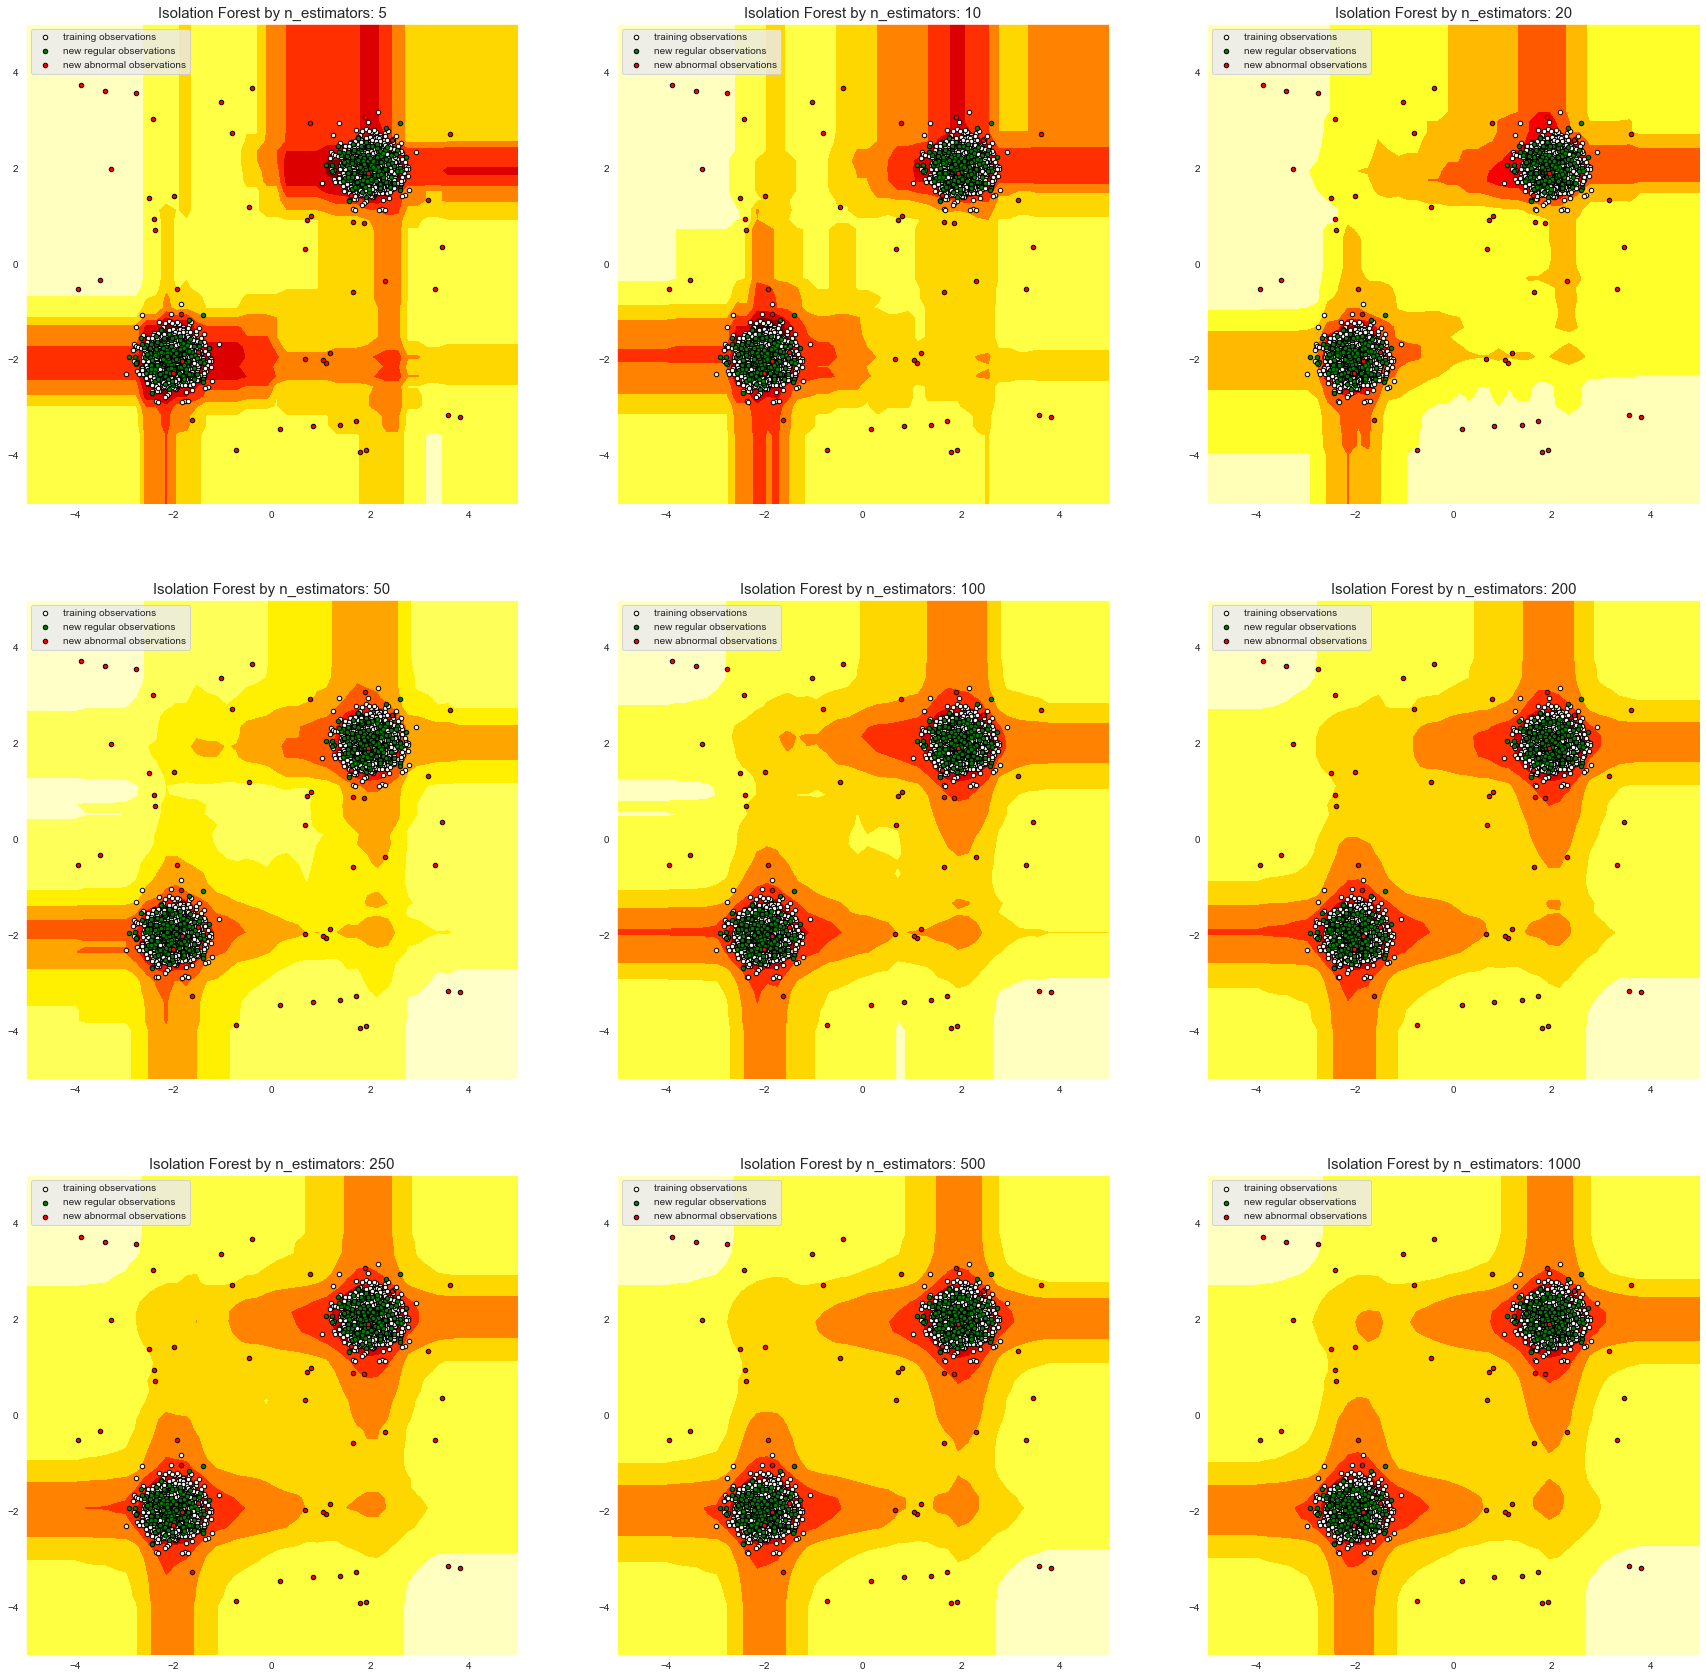

In [7]:
plt.rcParams['figure.figsize'] = [30, 30]

for i, n_estimator in enumerate(n_estimators_list):
    iforest = IsolationForest(n_estimators=n_estimator, random_state=42)
    iforest.fit(X)

    # plot the line, the samples, and the nearest vectors to the plane
    xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
    Z = iforest.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.subplot(3, 3, i+1)
    plt.contourf(xx, yy, Z, cmap=plt.cm.hot_r)

    b1 = plt.scatter(X_normal1.x1, X_normal1.x2, c="white", s=20, edgecolor="k")
    b2 = plt.scatter(X_normal2.x1, X_normal2.x2, c="green", s=20, edgecolor="k")
    c = plt.scatter(X_outliers.x1, X_outliers.x2, c="red", s=20, edgecolor="k")

    plt.axis("tight")
    plt.xlim((-5, 5))
    plt.ylim((-5, 5))
    plt.legend([b1, b2, c],
               ["training observations", "new regular observations", "new abnormal observations"],
               loc="upper left")

    plt.title(f"Isolation Forest by n_estimators: {n_estimator}", fontsize=15)

plt.show()

- ÏÇ¨Ïö©ÎêòÎäî Ï∂îÏ†ïÍ∏∞Ïùò Í∞úÏàòÏóê Îî∞Î•∏ Î≥ÄÌôîÎ•º Î≥¥Î©¥ Îã§ÏùåÍ≥º Í∞ôÏäµÎãàÎã§.

- ÏãúÍ∞ÅÌôî Í≤∞Í≥º, Ï∂îÏ†ïÍ∏∞Ïùò Í∞úÏàòÍ∞Ä Ï¶ùÍ∞ÄÌï†ÏàòÎ°ù Ïù¥ÏÉÅÏπò Ï†êÏàò Î∞ÄÎèÑÏùò ÌòïÌÉúÏóê ÎåÄÌï¥ÏÑú Ï°∞Í∏à Îçî ÏÑ∏Î∞ÄÌïú Î™®ÏäµÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÍ≥†,

- Í∞úÏàòÍ∞Ä Ïª§ÏßàÏàòÎ°ù Ï†ïÏÉÅÎç∞Ïù¥ÌÑ∞Í∞Ä Ï°¥Ïû¨ÌïòÏßÄ ÏïäÎäî ÎåÄÍ∞ÅÏÑ† Î∂ÄÎ∂Ñ (Ï¢åÏÉÅÎã® - Ïö∞ÌïòÎã®)Ïùò Î∂ÄÎ∂ÑÏùò Ïù¥ÏÉÅÏπò Ï†êÏàò Í∞íÏù¥ Îçî ÎÜíÏïÑÏßÄÎäî Í≤ÉÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏäµÎãàÎã§.

#### Real data AUROC ÎπÑÍµê

- Ïã§Ï†ú Îç∞Ïù¥ÌÑ∞ÏÖãÏóê ÎåÄÌïú ÎπÑÍµê Ïã§ÌóòÏùÑ ÏßÑÌñâÌï¥Î≥¥Í≤†ÏäµÎãàÎã§.

- Îç∞Ïù¥ÌÑ∞ÏÖãÏùÄ 2Ï∞®Ïõê Ïù¥ÏÉÅÏùò Ïù¥ÏÉÅÏπò ÌÉêÏßÄ ÏïåÍ≥†Î¶¨Îì¨ÏùÑ Î≤§ÏπòÎßàÌÇπÌïòÍ∏∞ ÏúÑÌïú Í∞ÄÏû• ÏùºÎ∞òÏ†ÅÏù∏ Îç∞Ïù¥ÌÑ∞ ÏÑ∏Ìä∏ Ï§ë ÌïòÎÇòÏù∏ "ÏúÑÏÑ±" Îç∞Ïù¥ÌÑ∞ ÏÑ∏Ìä∏Î°ú,
    ÏõêÎûò Îã§Ï§ë ÌÅ¥ÎûòÏä§ Î∂ÑÎ•òÎ•º ÏúÑÌï¥ ÏÑ§Í≥ÑÎêòÏóàÏßÄÎßå ÏùºÎ∞òÏ†ÅÏúºÎ°ú Í∞ÄÏû• Îçú ÏùºÎ∞òÏ†ÅÏù∏ ÌÅ¥ÎûòÏä§Î•º Ìï®Íªò Î≥ëÌï©ÌïòÍ≥† "Ïù¥ÏÉÅÏπò" ÎòêÎäî "Ïù¥ÏÉÅÏπò"Î°ú Î†àÏù¥Î∏îÏùÑ ÏßÄÏ†ïÌïòÏó¨ Ïù¥ÏÉÅÏπò ÌÉêÏßÄÏóê Ï†ÅÌï©Ìï©ÎãàÎã§.

In [8]:
sat = loadmat("satellite.mat")
X_features = sat["X"]
y_label = sat["y"]

# yÍ∞íÏùÄ -1 ÎòêÎäî 1
y_label = np.where(y_label == 1, -1, 0)
y_label = np.where(y_label == 0, 1, -1)

print("Dataset dimensions: (%d, %d)" % X_features.shape)
print("Percent anomalies: %.2f%%" % (100*y_label.mean()))

Dataset dimensions: (6435, 36)
Percent anomalies: 36.72%


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.3, random_state=42)

In [10]:
params = {"n_estimators": n_estimators_list}

# model define
clf = IsolationForest(random_state=42)

aurocsc = make_scorer(roc_auc_score)

# model train with gridsearchCV
grid_model_clf = GridSearchCV(clf, param_grid=params, cv=5, scoring=aurocsc, refit=True, return_train_score=True)
grid_model_clf.fit(X_train, y_train)

# print results
result = pd.DataFrame(grid_model_clf.cv_results_)

best_model_clf = grid_model_clf.best_estimator_

In [11]:
print("CV score")
result[["params"] + ["split" + str(i) + "_test_score" for i in range(5)] + ["std_test_score", "mean_test_score"]]

CV score


params  split0_test_score  split1_test_score  \
0     {'n_estimators': 5}           0.709708           0.645427   
1    {'n_estimators': 10}           0.712291           0.684967   
2    {'n_estimators': 20}           0.696691           0.697891   
3    {'n_estimators': 50}           0.701808           0.700315   
4   {'n_estimators': 100}           0.701262           0.701122   
5   {'n_estimators': 200}           0.701510           0.710638   
6   {'n_estimators': 250}           0.707273           0.713376   
7   {'n_estimators': 500}           0.699126           0.708057   
8  {'n_estimators': 1000}           0.695449           0.708057   

   split2_test_score  split3_test_score  split4_test_score  std_test_score  \
0           0.725625           0.740081           0.687421        0.033106   
1           0.707600           0.686175           0.697114        0.011011   
2           0.717506           0.714035           0.697030        0.009170   
3           0.701471           0.691177           0.670822        0.011815   
4           0.709033           0.715516           0.685950        0.009893   
5           0.711544           0.718087           0.692772        0.008824   
6           0.710716           0.727840           0.699594        0.009278   
7           0.709061           0.713225           0.688556        0.008817   
8           0.704866           0.707133           0.688598        0.007574   

   mean_test_score  
0         0.701653  
1         0.697630  
2         0.704631  
3         0.693119  
4         0.702577  
5         0.706910  
6         0.711760  
7         0.703605  
8         0.700821

- n_estimatorÏùò Í∞úÏàò Î≥ÄÌôîÏóê Îî∞Î•∏ Ïã§Ìóò Í≤∞Í≥º, AUROCÏùò Í∞íÏùÑ ÏßÄÌëúÎ°ú CV=5Î•º ÏÑ§Ï†ïÌï¥ ÎπÑÍµêÌñàÏùÑ ÎïåÏùò Î™®ÏäµÏûÖÎãàÎã§.
- Ìù•ÎØ∏Î°úÏö¥ Ï†êÏùÄ AUROC Í∞íÏùò Î≥ÄÌôîÍ∞Ä Ï∂îÏ†ïÍ∏∞ Í∞úÏàòÏùò Ï¶ùÍ∞êÏóê Îî∞Î•∏ Ìå®ÌÑ¥Ïù¥ Î≥¥Ïù¥ÏßÄ ÏïäÏïòÍ≥†, ÏÑ±Îä•Ïù¥ ÎπÑÏä∑ÎπÑÏä∑Ìïú Î™®ÏäµÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏäµÎãàÎã§.

In [12]:
print("Isolation Forest by n_estimator")
print("Best Parameter : " + str(grid_model_clf.best_params_))

# predict
pred = best_model_clf.predict(X_test)
# cross table
tab = pd.crosstab(y_test.ravel(), pred, rownames=["real"], colnames=["pred"])
print(tab)
print("Acc : " + str((tab.iloc[0, 0] + tab.iloc[1, 1]) / len(X_test)))

Isolation Forest by n_estimator
Best Parameter : {'n_estimators': 250}
pred   -1     1
real           
-1    251   355
 1     54  1271
Acc : 0.7881926462972553


- ÏµúÏ¢ÖÏ†ÅÏúºÎ°ú n_estimatorÏô∏Ïùò Î™®Îì† ÌååÎùºÎØ∏ÌÑ∞Î•º Í≥†Ï†ïÌïòÍ≥† Ïã§ÌóòÌïú Í≤∞Í≥º, n_estimator=250Ïùº Îïå Í≤∞Í≥ºÍ∞Ä Í∞ÄÏû• Ï¢ãÍ≤å ÎÇòÏôîÏäµÎãàÎã§.
- Ïù¥Î•º ÌÜµÌï¥, Ï∂îÏ†ïÍ∏∞Ïùò Í∞úÏàòÍ∞Ä ÎßéÎã§Í≥† Ìï¥ÏÑú Î¨¥Ï°∞Í±¥Ï†ÅÏù∏ ÏÑ±Îä•Ïùò Ï¶ùÍ∞Ä ÎêòÏßÄÎäî ÏïäÎäîÎã§Îäî Í≤ÉÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏóàÏäµÎãàÎã§.

### max_samples (np.sqrt(len(X)), 50, 100, 150, 200, 'auto', 500, 750, 1000)

In [13]:
max_samples_list = [np.int(np.sqrt(len(X))), 50, 100, 150, 200, 'auto', 500, 750, 1000] # default: 'auto': min(256, n_samples)

C:\Users\YongGon\AppData\Local\Temp/ipykernel_14480/1537380347.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_samples_list = [np.int(np.sqrt(len(X))), 50, 100, 150, 200, 'auto', 500, 750, 1000] # default: 'auto': min(256, n_samples)


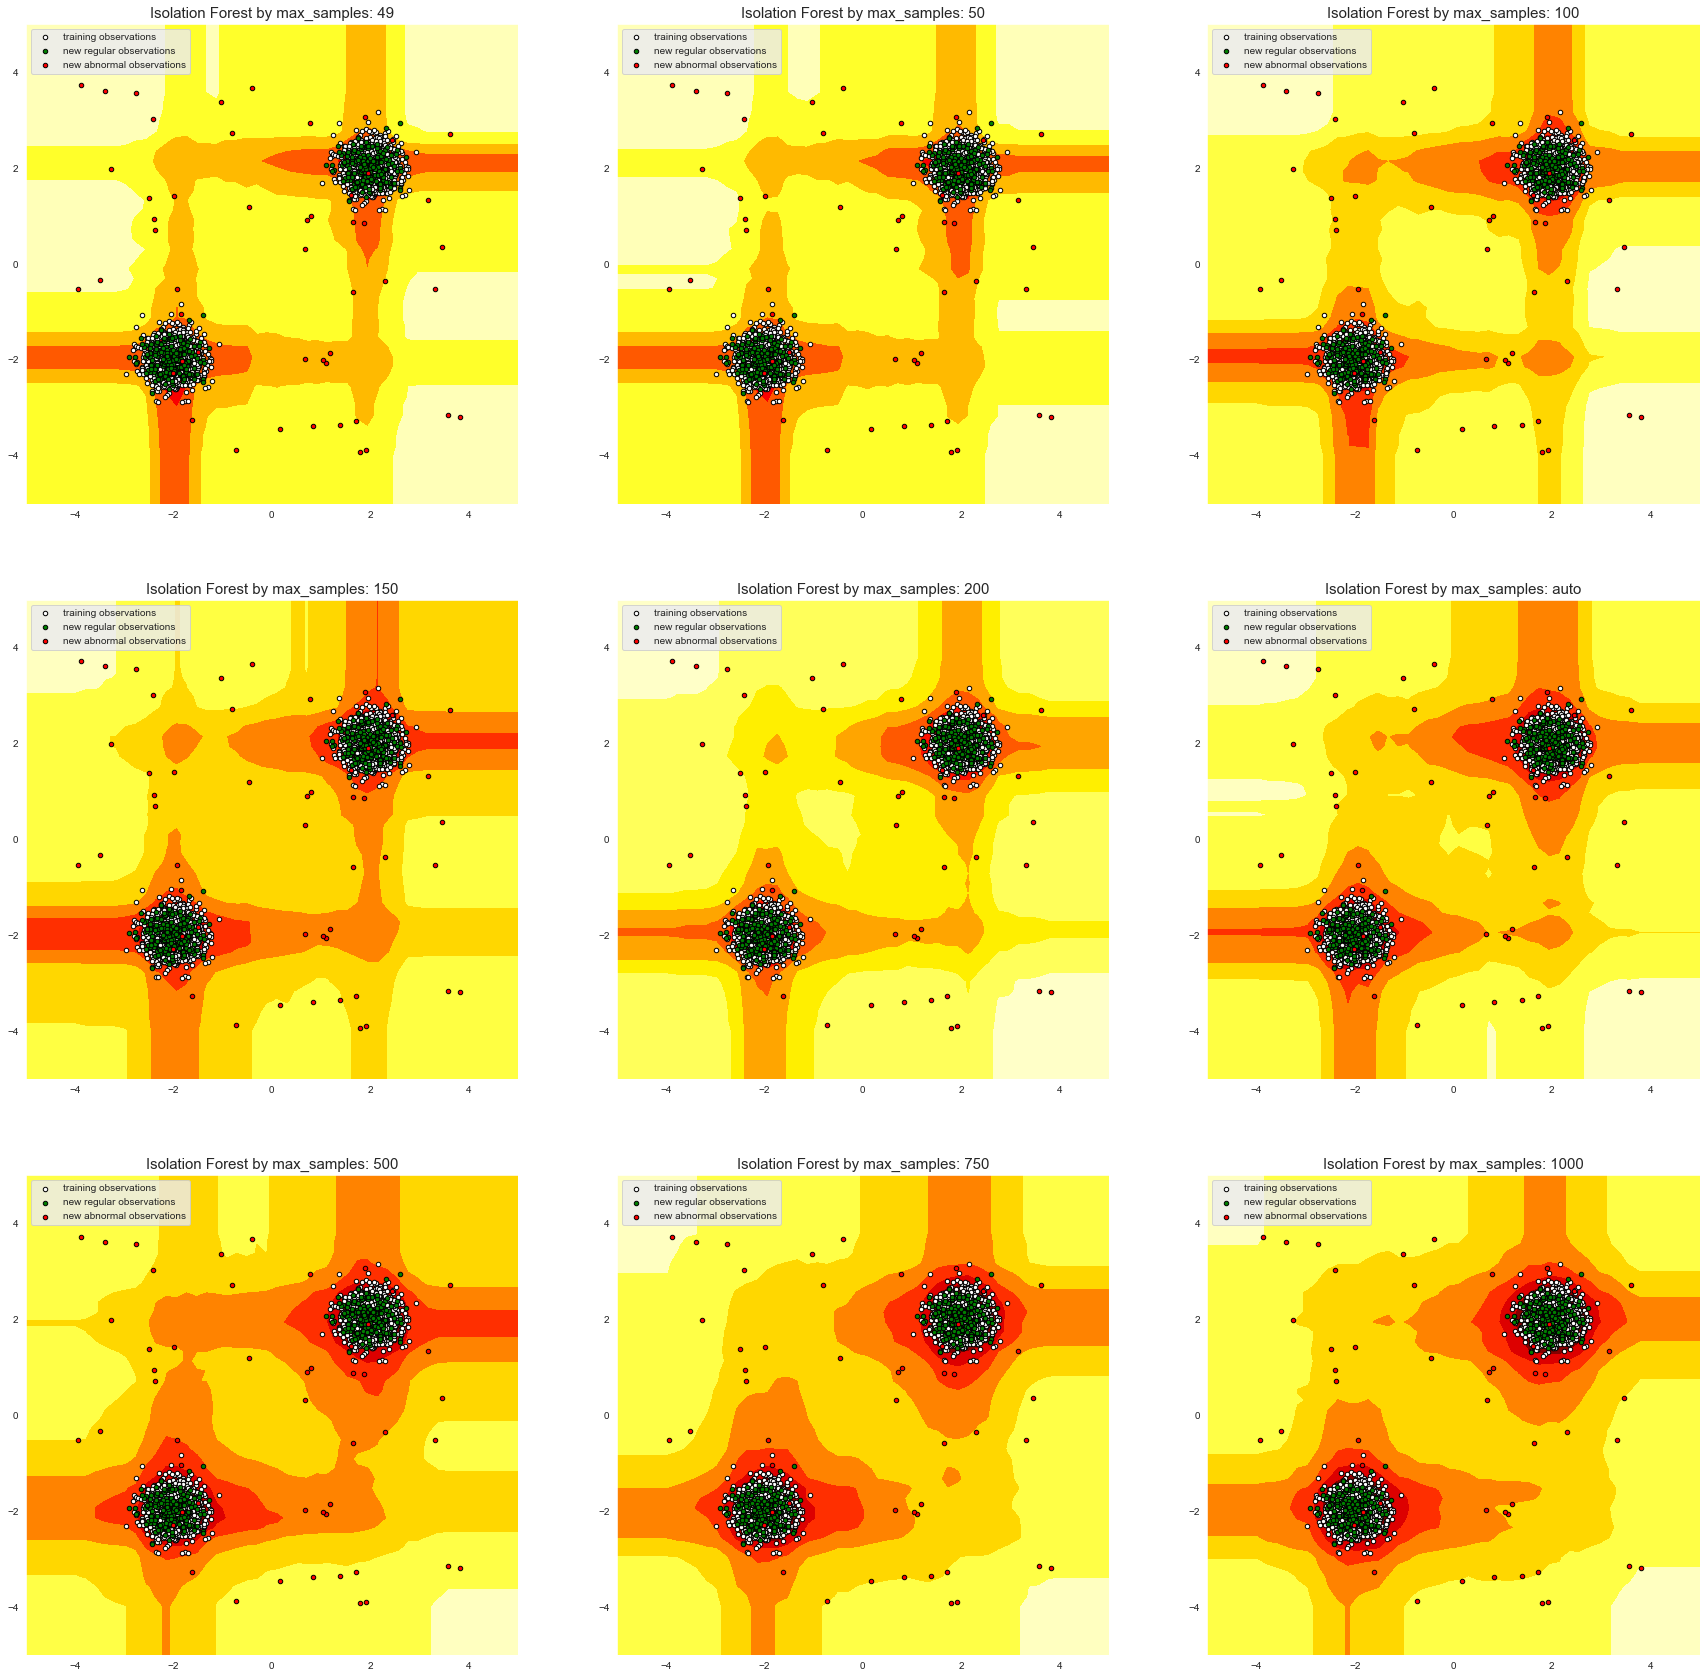

In [14]:
plt.rcParams['figure.figsize'] = [30, 30]

for i, max_sample in enumerate(max_samples_list):
    iforest = IsolationForest(max_samples=max_sample, random_state=42)
    iforest.fit(X)

    # plot the line, the samples, and the nearest vectors to the plane
    xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
    Z = iforest.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.subplot(3, 3, i+1)
    plt.contourf(xx, yy, Z, cmap=plt.cm.hot_r)

    b1 = plt.scatter(X_normal1.x1, X_normal1.x2, c="white", s=20, edgecolor="k")
    b2 = plt.scatter(X_normal2.x1, X_normal2.x2, c="green", s=20, edgecolor="k")
    c = plt.scatter(X_outliers.x1, X_outliers.x2, c="red", s=20, edgecolor="k")

    plt.axis("tight")
    plt.xlim((-5, 5))
    plt.ylim((-5, 5))
    plt.legend([b1, b2, c],
               ["training observations", "new regular observations", "new abnormal observations"],
               loc="upper left")

    plt.title(f"Isolation Forest by max_samples: {max_sample}", fontsize=15)

plt.show()

- Îã§ÏùåÏúºÎ°ú ÌïôÏäµÏãú ÏÇ¨Ïö©ÎêòÎäî Îç∞Ïù¥ÌÑ∞Ïùò Í∞úÏàò Î≥ÄÌôîÏóê Îî∞Î•∏ Í≤∞Í≥ºÎ•º Î≥¥Î©¥ Îã§ÏùåÍ≥º Í∞ôÏäµÎãàÎã§.

- ÏãúÍ∞ÅÌôî Í≤∞Í≥º, Îç∞Ïù¥ÌÑ∞Ïùò Í∞úÏàòÍ∞Ä Ï¶ùÍ∞ÄÌï†ÏàòÎ°ù ÎåÄÍ∞ÅÏÑ† Î∂ÄÎ∂Ñ (Ï¢åÏÉÅÎã® - Ïö∞ÌïòÎã®)Ïùò Î∂ÄÎ∂Ñ Î∞è ÎÇ¥Î∂Ä ÏÇ¨Í∞ÅÌòïÏùò Î∂ÄÎ∂ÑÏóê ÏûàÏñ¥ÏÑú Ïù¥ÏÉÅÏπò Ï†êÏàò Î∞ÄÎèÑÏùò Í∞íÏùò Î≥ÄÌôîÍ∞Ä ÏÉùÍπÄÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏóàÏäµÎãàÎã§.

#### Real data AUROC ÎπÑÍµê

In [15]:
params = {"max_samples": max_samples_list}

# model define
clf = IsolationForest(random_state=42)

aurocsc = make_scorer(roc_auc_score)

# model train with gridsearchCV
grid_model_clf = GridSearchCV(clf, param_grid=params, cv=5, scoring=aurocsc, refit=True, return_train_score=True)
grid_model_clf.fit(X_train, y_train)

# print results
result = pd.DataFrame(grid_model_clf.cv_results_)

best_model_clf = grid_model_clf.best_estimator_

In [16]:
print("CV score")
result[["params"] + ["split" + str(i) + "_test_score" for i in range(5)] + ["std_test_score", "mean_test_score"]]

CV score


params  split0_test_score  split1_test_score  \
0      {'max_samples': 49}           0.702901           0.694697   
1      {'max_samples': 50}           0.697387           0.684689   
2     {'max_samples': 100}           0.721632           0.709947   
3     {'max_samples': 150}           0.700914           0.700610   
4     {'max_samples': 200}           0.705932           0.705634   
5  {'max_samples': 'auto'}           0.701262           0.701122   
6     {'max_samples': 500}           0.661914           0.694523   
7     {'max_samples': 750}           0.641693           0.658096   
8    {'max_samples': 1000}           0.616753           0.640208   

   split2_test_score  split3_test_score  split4_test_score  std_test_score  \
0           0.689090           0.700961           0.668861        0.012230   
1           0.695741           0.710155           0.673862        0.012283   
2           0.697639           0.720045           0.695840        0.010814   
3           0.702410           0.707721           0.674548        0.011631   
4           0.714083           0.706462           0.691946        0.007158   
5           0.709033           0.715516           0.685950        0.009893   
6           0.694653           0.695731           0.673218        0.013899   
7           0.667690           0.673654           0.646883        0.012064   
8           0.652482           0.669043           0.635887        0.017409   

   mean_test_score  
0         0.691302  
1         0.692367  
2         0.709020  
3         0.697241  
4         0.704811  
5         0.702577  
6         0.684008  
7         0.657603  
8         0.642875

- max_samples Í∞úÏàò Î≥ÄÌôîÏóê Îî∞Î•∏ Ïã§Ìóò Í≤∞Í≥º, AUROCÏùò Í∞íÏùÑ ÏßÄÌëúÎ°ú CV=5Î•º ÏÑ§Ï†ïÌï¥ ÎπÑÍµêÌñàÏùÑ ÎïåÏùò Î™®ÏäµÏûÖÎãàÎã§.
- Ìù•ÎØ∏Î°úÏö¥ Ï†êÏùÄ AUROC Í∞íÏùò Î≥ÄÌôîÎ•º ÏÇ¥Ìé¥Î≥¥Î©¥, ÏùºÏ†ï Ïàò Ïù¥Ìïò(500 ÎØ∏Îßå)Ïùò Í∞íÏùÑ ÏÑ§Ï†ïÌïú Í≤ΩÏö∞ ÎπÑÏä∑Ìïú Í≤∞Í≥ºÎ•º Î≥¥Ïù¥ÏßÄÎßå, ÏùºÏ†ï Ïàò Ïù¥ÏÉÅÏùò Îç∞Ïù¥ÌÑ∞ Í∞úÏàòÎ•º ÏßÄÏ†ïÌïòÎ©¥(500 Ïù¥ÏÉÅ) AUROC Í∞íÏù¥ ÌïòÎùΩÎêòÎäî Î™®ÏäµÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏäµÎãàÎã§.

In [17]:
print("Isolation Forest by max_sample")
print("Best Parameter : " + str(grid_model_clf.best_params_))

# predict
pred = best_model_clf.predict(X_test)
# cross table
tab = pd.crosstab(y_test.ravel(), pred, rownames=["real"], colnames=["pred"])
print(tab)
print("Acc : " + str((tab.iloc[0, 0] + tab.iloc[1, 1]) / len(X_test)))

Isolation Forest by max_sample
Best Parameter : {'max_samples': 100}
pred   -1     1
real           
-1    260   346
 1     92  1233
Acc : 0.7731745209735889


- ÏµúÏ¢ÖÏ†ÅÏúºÎ°ú max_samplesÏô∏Ïùò Î™®Îì† ÌååÎùºÎØ∏ÌÑ∞Î•º Í≥†Ï†ïÌïòÍ≥† Ïã§ÌóòÌïú Í≤∞Í≥º, max_sample=100Ïùº Îïå Í≤∞Í≥ºÍ∞Ä Í∞ÄÏû• Ï¢ãÍ≤å ÎÇòÏôîÏäµÎãàÎã§.
- Ïù¥Î•º ÌÜµÌï¥, ÏÇ¨Ïö©ÎêòÎäî Îç∞Ïù¥ÌÑ∞Ïùò Í∞úÏàòÍ∞Ä ÎßéÎã§Í≥† Ìï¥ÏÑú Î¨¥Ï°∞Í±¥Ï†ÅÏù∏ ÏÑ±Îä•Ïùò Ï¶ùÍ∞Ä ÎêòÏßÄÎäî ÏïäÎäîÎã§Îäî Í≤ÉÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏóàÏäµÎãàÎã§.
- ÎòêÌïú, Isolation ForestÏùò ÌäπÏßï Í∞ÄÏö¥Îç∞ <Sub-sampling: Ï†ÑÏàò Îç∞Ïù¥ÌÑ∞Í∞Ä ÏïÑÎãå samplingÌïú Îç∞Ïù¥ÌÑ∞Î°ú Î™®Îç∏ÏùÑ ÏÉùÏÑ± (Íµ∞ÏßëÌôî Ïù¥ÏÉÅÌÉêÏßÄ Î∞©ÏãùÏùÄ Ï†ÑÏàòÎç∞Ïù¥ÌÑ∞Î•º ÏÇ¨Ïö©Ìï¥Ïïº Ìï®)>Ïóê ÎåÄÌïú Î∂ÄÎ∂ÑÎèÑ Ïñ¥ÎäêÏ†ïÎèÑ ÏÑ§Î™ÖÌï† Ïàò ÏûàÎã§Í≥† ÏÉùÍ∞ÅÌñàÏäµÎãàÎã§.

### contamination (0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 'auto')

In [18]:
contaminations_list = list(np.round(np.arange(0.1, 0.51, 0.05), 3))
contaminations_list.append('auto')
contaminations_list

[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 'auto']

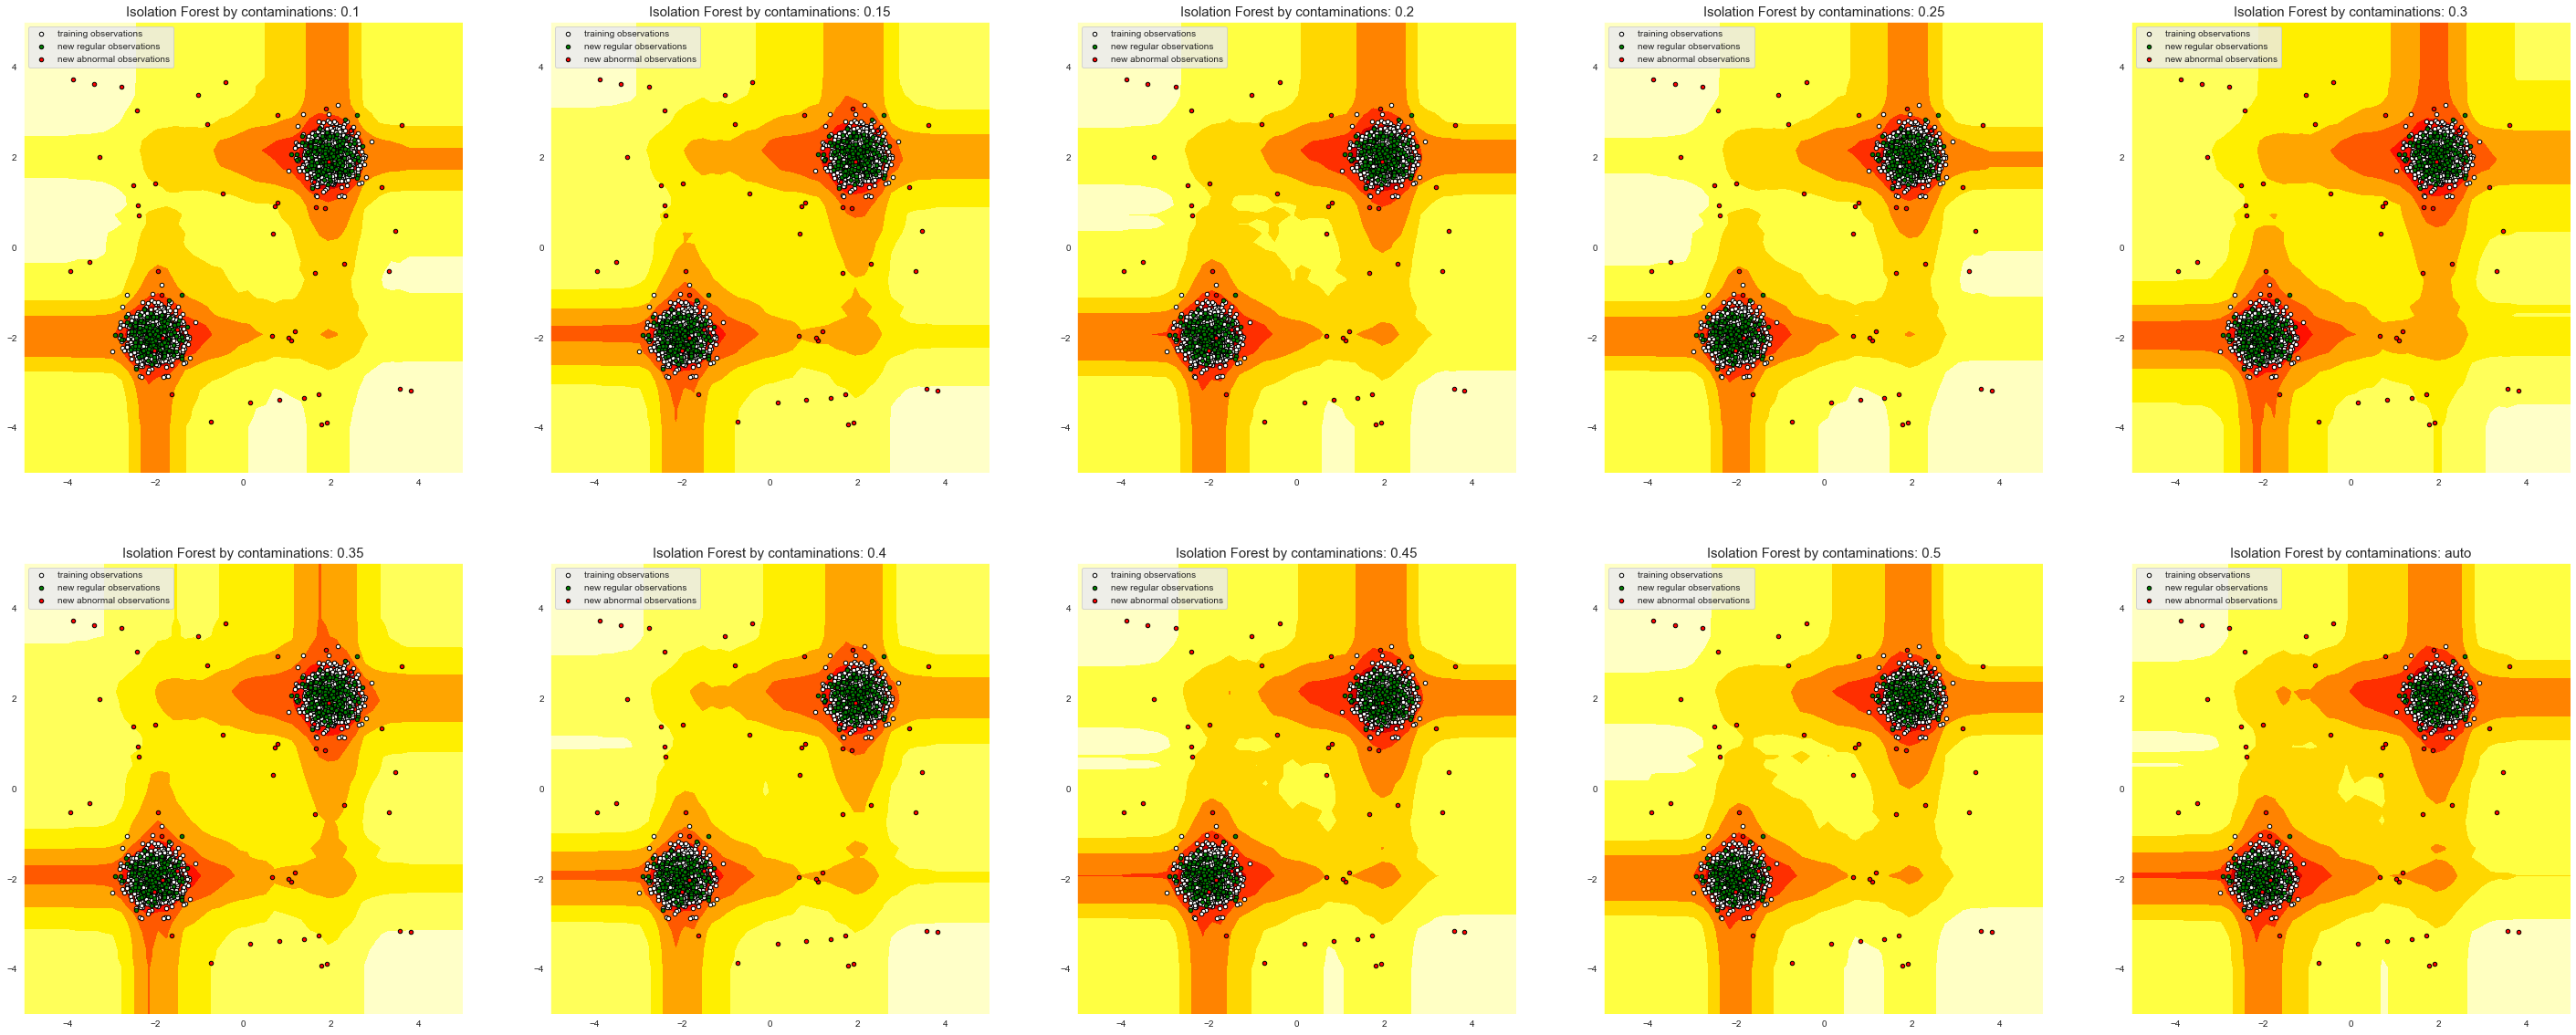

In [19]:
plt.rcParams['figure.figsize'] = [50, 20]

for i, cont in enumerate(contaminations_list):
    iforest = IsolationForest(contamination=cont, random_state=42)
    iforest.fit(X)

    # plot the line, the samples, and the nearest vectors to the plane
    xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
    Z = iforest.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.subplot(2, 5, i+1)
    plt.contourf(xx, yy, Z, cmap=plt.cm.hot_r)

    b1 = plt.scatter(X_normal1.x1, X_normal1.x2, c="white", s=20, edgecolor="k")
    b2 = plt.scatter(X_normal2.x1, X_normal2.x2, c="green", s=20, edgecolor="k")
    c = plt.scatter(X_outliers.x1, X_outliers.x2, c="red", s=20, edgecolor="k")

    plt.axis("tight")
    plt.xlim((-5, 5))
    plt.ylim((-5, 5))
    plt.legend([b1, b2, c],
               ["training observations", "new regular observations", "new abnormal observations"],
               loc="upper left")

    plt.title(f"Isolation Forest by contaminations: {cont}", fontsize=15)

plt.show()

- ÏÇ¨Ïö©ÎêòÎäî Î™®Îç∏Ïùò Ïù¥ÏÉÅÏπò ÎπÑÏú®Ïóê ÎåÄÌïú Î≥ÄÌôîÏóê ÎåÄÌï¥ Í≤∞Í≥ºÎ•º Î≥¥Î©¥ Îã§ÏùåÍ≥º Í∞ôÏäµÎãàÎã§.
- ÏãúÍ∞ÅÌôî Í≤∞Í≥º, Ïù¥ÏÉÅÏπò ÎπÑÏú®Ïù¥ Ï¶ùÍ∞ÄÌï†ÏàòÎ°ù Í≤∞Ï†ï Í≤ΩÍ≥ÑÎ•º ÏßÄÎÇòÏπòÍ≤å Ï¢ÅÍ≤å Ïû°ÏïÑ Ï†ïÏÉÅ Îç∞Ïù¥ÌÑ∞Î•º Ïò§Î∂ÑÎ•òÌïòÎäî Í≤ΩÏö∞Î•º ÌôïÏù∏Ìï† Ïàò ÏûàÏäµÎãàÎã§.
- Í∑∏ÎûòÏÑú ÏùºÎ∞òÏ†ÅÏúºÎ°úÎäî, Ïã§Ï†ú Ïù¥ÏÉÅÏπò ÎπÑÏú®Í≥º ÌååÎùºÎØ∏ÌÑ∞ ÏÑ§Ï†ï ÎπÑÏú®Ïù¥ Í∞ôÏùÑ Îïå Ìï©Î¶¨Ï†ÅÏù∏ Í≤∞Ï†ï Í≤ΩÍ≥ÑÎ•º Í∑∏Î¶¨Îäî Í≤ΩÏö∞Í∞Ä ÎßéÏäµÎãàÎã§.

#### Real data AUROC ÎπÑÍµê

In [20]:
params = {"contamination": contaminations_list}

# model define
clf = IsolationForest(random_state=42)

aurocsc = make_scorer(roc_auc_score)

# model train with gridsearchCV
grid_model_clf = GridSearchCV(clf, param_grid=params, cv=5, scoring=aurocsc, refit=True, return_train_score=True)
grid_model_clf.fit(X_train, y_train)

# print results
result = pd.DataFrame(grid_model_clf.cv_results_)

best_model_clf = grid_model_clf.best_estimator_

In [21]:
print("CV score")
result[["params"] + ["split" + str(i) + "_test_score" for i in range(5)] + ["std_test_score", "mean_test_score"]]

CV score


params  split0_test_score  split1_test_score  \
0     {'contamination': 0.1}           0.627583           0.633609   
1    {'contamination': 0.15}           0.688692           0.700492   
2     {'contamination': 0.2}           0.709807           0.720448   
3    {'contamination': 0.25}           0.718253           0.717630   
4     {'contamination': 0.3}           0.713831           0.714674   
5    {'contamination': 0.35}           0.709360           0.716722   
6     {'contamination': 0.4}           0.697834           0.706496   
7    {'contamination': 0.45}           0.673887           0.684666   
8     {'contamination': 0.5}           0.659181           0.659606   
9  {'contamination': 'auto'}           0.701262           0.701122   

   split2_test_score  split3_test_score  split4_test_score  std_test_score  \
0           0.650715           0.661721           0.663622        0.014575   
1           0.703099           0.706294           0.681650        0.009337   
2           0.719385           0.721665           0.694887        0.010093   
3           0.715580           0.707527           0.694649        0.008906   
4           0.707637           0.699871           0.685152        0.010916   
5           0.688020           0.674387           0.677308        0.017016   
6           0.661781           0.662540           0.674464        0.018361   
7           0.642880           0.655723           0.656577        0.014742   
8           0.620669           0.625739           0.647205        0.016435   
9           0.709033           0.715516           0.685950        0.009893   

   mean_test_score  
0         0.647450  
1         0.696046  
2         0.713239  
3         0.710728  
4         0.704233  
5         0.693159  
6         0.680623  
7         0.662747  
8         0.642480  
9         0.702577

- contaminationÏùò ÎπÑÏú® Î≥ÄÌôîÏóê Îî∞Î•∏ Ïã§Ìóò Í≤∞Í≥º, AUROCÏùò Í∞íÏùÑ ÏßÄÌëúÎ°ú CV=5Î•º ÏÑ§Ï†ïÌï¥ ÎπÑÍµêÌñàÏùÑ ÎïåÏùò Î™®ÏäµÏûÖÎãàÎã§.
- Ìù•ÎØ∏Î°úÏö¥ Ï†êÏùÄ AUROC Í∞íÏùò Î≥ÄÌôîÍ∞Ä ÏßÄÎÇòÏπòÍ≤å ÎÇÆÏùÄ ÎπÑÏú®(0.1)Í≥º ÏßÄÎÇòÏπòÍ≤å ÎÜíÏùÄ ÎπÑÏú®(0.4, 0.45, 0.5)Ïùò Í≤ΩÏö∞ ÏÑ±Îä•Ïù¥ ÌïòÎùΩÎêòÎäî Î™®ÏäµÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏóàÍ≥†, Ï†ÅÎãπÌïú ÎπÑÏú®Ïùò Í≤ΩÏö∞ Îã§Î•∏ Í≤ΩÏö∞Îì§Í≥º ÎπÑÏä∑Ìïú ÏÑ±Îä•ÏùÑ Î≥¥ÏûÑÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏóàÏäµÎãàÎã§.

In [22]:
print("Isolation Forest by contamination")
print("Best Parameter : " + str(grid_model_clf.best_params_))

# predict
pred = best_model_clf.predict(X_test)
# cross table
tab = pd.crosstab(y_test.ravel(), pred, rownames=["real"], colnames=["pred"])
print(tab)
print("Acc : " + str((tab.iloc[0, 0] + tab.iloc[1, 1]) / len(X_test)))

Isolation Forest by contamination
Best Parameter : {'contamination': 0.2}
pred   -1     1
real           
-1    269   337
 1     75  1250
Acc : 0.7866390471258415


- ÏµúÏ¢ÖÏ†ÅÏúºÎ°ú contaminationÏô∏Ïùò Î™®Îì† ÌååÎùºÎØ∏ÌÑ∞Î•º Í≥†Ï†ïÌïòÍ≥† Ïã§ÌóòÌïú Í≤∞Í≥º, contamination=0.2Ïùº Îïå Í≤∞Í≥ºÍ∞Ä Í∞ÄÏû• Ï¢ãÍ≤å ÎÇòÏôîÏäµÎãàÎã§.
- Ïù¥Î•º ÌÜµÌï¥, Ïù¥ÏÉÅÏπò ÎπÑÏú®ÏùÑ ÏùòÎèÑÏ†ÅÏúºÎ°ú ÎäòÎ¶¨Îäî Í≤ÉÏóê ÎåÄÌï¥ÏÑú Î¨¥Ï°∞Í±¥Ï†ÅÏù∏ ÏÑ±Îä•Ïùò Ï¶ùÍ∞Ä ÎêòÏßÄÎäî ÏïäÎäîÎã§Îäî Í≤ÉÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏóàÍ≥†,
- Ïù¥ Î∂ÄÎ∂ÑÏùÄ Ïã§Ï†ú Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌï¥Ìïú Ïù¥Ìï¥ÎèÑÍ∞Ä ÎÜíÏïÑÏïºÏßÄ ÎπÑÏú®ÏùÑ Ï∂îÎ¶¨Ìï¥ÏÑú ÏÑ§Ï†ïÌïòÍ∏∞ ÎïåÎ¨∏Ïóê ÏÇ¨Ïö©ÌïòÎäî Îç∞Ïù¥ÌÑ∞ÏÖãÏóê ÎåÄÌïú ÎèÑÎ©îÏù∏Ï†ÅÏù∏ ÏßÄÏãùÏù¥ ÌïÑÏöîÌïú Î∂ÄÎ∂ÑÏù¥ÎùºÍ≥† ÏÉùÍ∞ÅÌñàÍ≥†, Î™®Îç∏ÏùÑ ÏÇ¨Ïö©Ìï®Ïóê ÏûàÏñ¥ Ï§ëÏöîÌïú ÌååÎùºÎØ∏ÌÑ∞ Ï§ë ÌïòÎÇòÎùºÍ≥† ÏÉùÍ∞ÅÌñàÏäµÎãàÎã§.

### max_features (1, 2)

In [23]:
max_features_list = [1, 2]  # default: 1.0

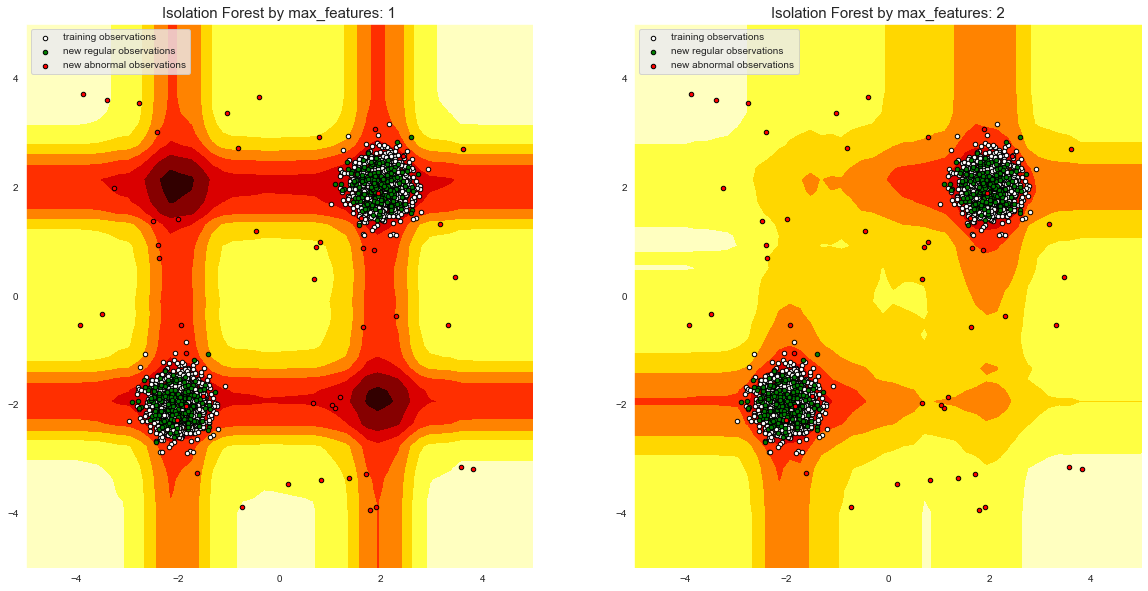

In [24]:
plt.rcParams['figure.figsize'] = [20, 10]

for i, max_feature in enumerate(max_features_list):
    iforest = IsolationForest(max_features=max_feature, random_state=42)
    iforest.fit(X)

    # plot the line, the samples, and the nearest vectors to the plane
    xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
    Z = iforest.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.subplot(1, 2, i+1)
    plt.contourf(xx, yy, Z, cmap=plt.cm.hot_r)

    b1 = plt.scatter(X_normal1.x1, X_normal1.x2, c="white", s=20, edgecolor="k")
    b2 = plt.scatter(X_normal2.x1, X_normal2.x2, c="green", s=20, edgecolor="k")
    c = plt.scatter(X_outliers.x1, X_outliers.x2, c="red", s=20, edgecolor="k")

    plt.axis("tight")
    plt.xlim((-5, 5))
    plt.ylim((-5, 5))
    plt.legend([b1, b2, c],
               ["training observations", "new regular observations",
                   "new abnormal observations"],
               loc="upper left")

    plt.title(f"Isolation Forest by max_features: {max_feature}", fontsize=15)

plt.show()

- ÏÇ¨Ïö©ÎêòÎäî feature Í∞úÏàòÏóê Îî∞Î•∏ Î≥ÄÌôîÎ•º Î≥¥Î©¥ Îã§ÏùåÍ≥º Í∞ôÏäµÎãàÎã§. Ïö∞ÏÑ† ÏÉùÏÑ± Îç∞Ïù¥ÌÑ∞ÏÖãÏóê ÎåÄÌïú Ïã§ÌóòÏúºÎ°ú Î≥ÄÏàòÎäî x1, x2Î°ú Îëê Í∞ú Î∞ñÏóê ÏóÜÎäî Ï†ê ÏñëÌï¥Î∞îÎûçÎãàÎã§.
- ÏãúÍ∞ÅÌôî Í≤∞Í≥º, featureÏùò Í∞úÏàòÎ•º ÎßéÏù¥ ÏÇ¨Ïö©Ìï† ÏàòÎ°ù ÎåÄÍ∞ÅÏÑ† Î∂ÄÎ∂Ñ (Ï¢åÏÉÅÎã® - Ïö∞ÌïòÎã®)Ïùò Î∂ÄÎ∂ÑÏùò Ïù¥ÏÉÅÏπò Ï†êÏàò Í∞íÏù¥ ÌÅ¨Í≤å Î≥ÄÌôîÌï®ÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏäµÎãàÎã§.

#### Real data AUROC ÎπÑÍµê

In [25]:
params = {"max_features": max_features_list}

# model define
clf = IsolationForest(random_state=42)

aurocsc = make_scorer(roc_auc_score)

# model train with gridsearchCV
grid_model_clf = GridSearchCV(clf, param_grid=params, cv=5, scoring=aurocsc, refit=True, return_train_score=True)
grid_model_clf.fit(X_train, y_train)

# print results
result = pd.DataFrame(grid_model_clf.cv_results_)

best_model_clf = grid_model_clf.best_estimator_

In [26]:
print("CV score")
result[["params"] + ["split" + str(i) + "_test_score" for i in range(5)] + ["std_test_score", "mean_test_score"]]

CV score


params  split0_test_score  split1_test_score  \
0  {'max_features': 1}           0.709261           0.721156   
1  {'max_features': 2}           0.714577           0.700432   

   split2_test_score  split3_test_score  split4_test_score  std_test_score  \
0           0.691490           0.677654           0.704679        0.014989   
1           0.704922           0.691374           0.695798        0.007986   

   mean_test_score  
0         0.700848  
1         0.701420

- max_featuresÏùò Í∞úÏàò Î≥ÄÌôîÏóê Îî∞Î•∏ Ïã§Ìóò Í≤∞Í≥º, AUROCÏùò Í∞íÏùÑ ÏßÄÌëúÎ°ú CV=5Î•º ÏÑ§Ï†ïÌï¥ ÎπÑÍµêÌñàÏùÑ ÎïåÏùò Î™®ÏäµÏûÖÎãàÎã§.
- Ìù•ÎØ∏Î°úÏö¥ Ï†êÏùÄ ÏúÑÏùò Í∑∏Î¶ºÍ≥º Îç∞Ïù¥ÌÑ∞Îäî Îã§Î•¥ÏßÄÎßå Í∑πÏ†ÅÏù∏ Î≥ÄÌôîÍ∞Ä ÏûàÏùÑ Í≤ÉÏúºÎ°ú Í∏∞ÎåÄÌñàÏäµÎãàÎã§.
- ÌïòÏßÄÎßå, AUROC Í∞íÏùò Î≥ÄÌôîÍ∞Ä max_features ÏàòÏùò Î≥ÄÌôîÏóêÎèÑ ÌÅ¨Í≤å Îã§Î•¥ÏßÄ ÏïäÍ≥†, ÏÑ±Îä•Ïù¥ ÎπÑÏä∑Ìïú Î™®ÏäµÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏäµÎãàÎã§.

In [27]:
print("Isolation Forest by max_feature")
print("Best Parameter : " + str(grid_model_clf.best_params_))

# predict
pred = best_model_clf.predict(X_test)
# cross table
tab = pd.crosstab(y_test.ravel(), pred, rownames=["real"], colnames=["pred"])
print(tab)
print("Acc : " + str((tab.iloc[0, 0] + tab.iloc[1, 1]) / len(X_test)))

Isolation Forest by max_feature
Best Parameter : {'max_features': 2}
pred   -1     1
real           
-1    260   346
 1    104  1221
Acc : 0.7669601242879337


- ÏµúÏ¢ÖÏ†ÅÏúºÎ°ú max_featuresÏô∏Ïùò Î™®Îì† ÌååÎùºÎØ∏ÌÑ∞Î•º Í≥†Ï†ïÌïòÍ≥† Ïã§ÌóòÌïú Í≤∞Í≥º, max_features=2Ïùº Îïå Í≤∞Í≥ºÍ∞Ä Í∞ÄÏû• Ï¢ãÍ≤å ÎÇòÏôîÏäµÎãàÎã§.
- Ïù¥Î•º ÌÜµÌï¥, max_featuresÏùò Í∞úÏàò ÎπÑÍµêÏóê ÎåÄÌï¥ÏÑúÎäî Ïú†ÏùòÎØ∏Ìïú ÏÑ±Îä•Ïùò ÌôïÏù∏Ïù¥ ÎêòÏßÄÎäî ÏïäÏïòÏßÄÎßå, Í∑∏ÎûòÎèÑ ÏÇ¨Ïö©ÌïòÎäî iTree Íµ¨ÏÑ±Ïóê ÏûàÏñ¥ÏÑú featureÏùò Í∞úÏàòÍ∞Ä ÎäòÏñ¥ÎÇòÎ©¥ Ï¢ãÏùÄ Í≤∞Í≥ºÍ∞Ä ÎÇòÏò¨ Í≤ÉÏù¥ÎùºÎäî ÏÉùÍ∞ÅÏù¥ Îì≠ÎãàÎã§.

### AUROC & ACC ÏµúÏ¢Ö ÎπÑÍµê (Hyperparameters) (With Real dataset)

In [28]:
params = {"n_estimators": n_estimators_list, "max_samples": max_samples_list,
          "contamination": contaminations_list, "max_features": [1, 2, 3, 5, 10]}  # ÏÉùÏÑ± Îç∞Ïù¥ÌÑ∞ÏôÄÎäî Îã§Î•¥Í≤å Î≥ÄÏàò 5Í∞úÍπåÏßÄ ÎäòÎ†§Î¥Ñ

# model define
clf = IsolationForest(random_state=42)

aurocsc = make_scorer(roc_auc_score)

# model train with gridsearchCV
grid_model_clf = GridSearchCV(clf, param_grid=params, cv=5, scoring=aurocsc, refit=True, return_train_score=True)
grid_model_clf.fit(X_train, y_train)

# print results
result = pd.DataFrame(grid_model_clf.cv_results_)

best_model_clf = grid_model_clf.best_estimator_

In [29]:
print("CV score")
result[["params"] + ["split" + str(i) + "_test_score" for i in range(5)] + ["std_test_score", "mean_test_score"]]

CV score


params  split0_test_score  \
0     {'contamination': 0.1, 'max_features': 1, 'max...           0.512818   
1     {'contamination': 0.1, 'max_features': 1, 'max...           0.613076   
2     {'contamination': 0.1, 'max_features': 1, 'max...           0.630217   
3     {'contamination': 0.1, 'max_features': 1, 'max...           0.620479   
4     {'contamination': 0.1, 'max_features': 1, 'max...           0.649642   
...                                                 ...                ...   
4045  {'contamination': 'auto', 'max_features': 10, ...           0.656151   
4046  {'contamination': 'auto', 'max_features': 10, ...           0.645121   
4047  {'contamination': 'auto', 'max_features': 10, ...           0.643531   
4048  {'contamination': 'auto', 'max_features': 10, ...           0.633545   
4049  {'contamination': 'auto', 'max_features': 10, ...           0.638265   

      split1_test_score  split2_test_score  split3_test_score  \
0              0.562154           0.563675           0.579702   
1              0.629413           0.611334           0.635872   
2              0.631028           0.638903           0.638163   
3              0.635539           0.639731           0.632741   
4              0.641509           0.638903           0.634362   
...                 ...                ...                ...   
4045           0.675512           0.662611           0.685028   
4046           0.653585           0.655905           0.679746   
4047           0.649881           0.657589           0.680556   
4048           0.646335           0.654222           0.672704   
4049           0.649074           0.667690           0.678935   

      split4_test_score  std_test_score  mean_test_score  
0              0.531307        0.024285         0.549931  
1              0.618770        0.009494         0.621693  
2              0.645805        0.005727         0.636823  
3              0.650889        0.009872         0.635876  
4              0.650932        0.006334         0.643070  
...                 ...             ...              ...  
4045           0.652795        0.012120         0.666419  
4046           0.652010        0.011797         0.657273  
4047           0.651184        0.012807         0.656548  
4048           0.646925        0.012838         0.650746  
4049           0.650315        0.014518         0.656856  

[4050 rows x 8 columns]

- ÏµúÏ¢ÖÏ†ÅÏúºÎ°ú 'ÏúÑÏÑ±' Îç∞Ïù¥ÌÑ∞ÏÖãÏóê ÎåÄÌï¥ Î™®Îì† ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞Ïóê ÎåÄÌïú gridsearchCVÎ•º ÏßÑÌñâÌïú Í≤∞Í≥º,
- Îã§ÏùåÍ≥º Í∞ôÏù¥ 4050Í∞ú caseÏùò Ïã§ÌóòÏùÑ ÏßÑÌñâÌñàÍ≥† ÏµúÏ†ÅÏùò ÌååÎùºÎØ∏ÌÑ∞Î•º Ï∞æÎäî Í≥ºÏ†ïÏùÑ ÏßÑÌñâÌñàÏäµÎãàÎã§.

In [56]:
print("Isolation Forest by gridsearchCV")
print("Best Parameter : " + str(grid_model_clf.best_params_))

# predict
pred = best_model_clf.predict(X_test)
# cross table
tab = pd.crosstab(y_test.ravel(), pred, rownames=["real"], colnames=["pred"])
print(tab)
print("Acc : " + str((tab.iloc[0, 0] + tab.iloc[1, 1]) / len(X_test)))

Isolation Forest by gridsearchCV
Best Parameter : {'contamination': 0.25, 'max_features': 3, 'max_samples': 750, 'n_estimators': 20}
pred   -1     1
real           
-1    321   285
 1    124  1201
Acc : 0.7881926462972553


- Í≤∞Í≥º, Best Parameter : {'contamination': 0.25, 'max_features': 3, 'max_samples': 750, 'n_estimators': 20}Ïùº Îïå AUROCÏùò Í∞íÏù¥ Í∞ÄÏû• Ï¢ãÍ≤å ÎÇòÏôîÍ≥†,
- Ïù¥ Î™®Îç∏ÏùÑ ÏÇ¨Ïö©Ìï¥ testsetÏùÑ Î∂ÑÎ•òÌïú Í≤∞Í≥º, 78.82%Ïùò Ï†ïÌôïÎèÑÎ•º Îã¨ÏÑ±Ìï† Ïàò ÏûàÏóàÏäµÎãàÎã§.

## Isolation Forest ÏïåÍ≥†Î¶¨Ï¶òÎ≥Ñ ÏÑ§Î™Ö

- Îã§ÏùåÎ∂ÄÌÑ∞Îäî Isolation ForestÎ•º Íµ¨ÏÑ±ÌïòÎäî ÏïåÍ≥†Î¶¨Ï¶òÎì§Ïóê ÎåÄÌï¥ Í∞ÅÍ∞Å ÏÑ§Î™ÖÏùÑ ÌïòÍ≥†, Ïù¥Î•º Íµ¨ÌòÑÌïòÎäî Í≥ºÏ†ïÏûÖÎãàÎã§.

### Algorithm 2 (iTree)

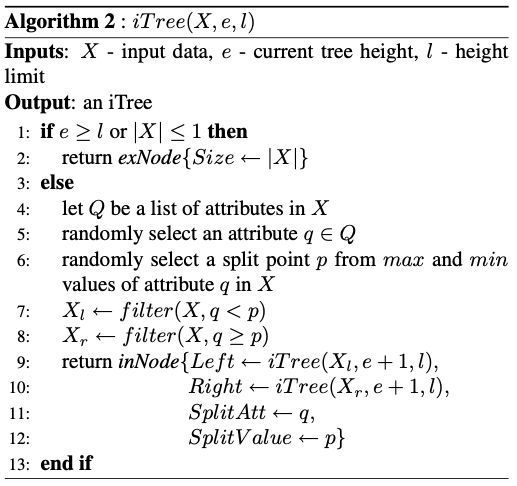

    1. ÏÉòÌîåÎßÅÎêú X‚Ä≤Í∞Ä IsolationÏù¥ ÎêúÎã§Î©¥ external nodeÎ°ú Î∞òÌôò
    4. X‚Ä≤Ïùò Î≥ÄÏàòÎ•º QÎùºÎäî listÏóê Ï†ÄÏû•
        5. ÎûúÎç§ÌïòÍ≤å Î≥ÄÏàòÎ•º ÏÑ†ÌÉù
        6. ÎûúÎç§ÌïòÍ≤å splitÌï† pÎ•º Ìï¥Îãπ Î≥ÄÏàòÏùò ÏµúÎåÄÍ∞íÍ≥º ÏµúÏÜåÍ∞íÏóêÏÑú ÏÑ†ÌÉù
        7. pÍ∞í Î≥¥Îã§ ÏûëÏùÄ Îç∞Ïù¥ÌÑ∞Îäî Xl(left)Î°ú Ìï†Îãπ
        8. pÍ∞í Î≥¥Îã§ ÌÅ∞ Îç∞Ïù¥ÌÑ∞Îäî Xl(right)Î°ú Ìï†Îãπ
    9. Ïû¨Í∑ÄÏ†ÅÏúºÎ°ú Îç∞Ïù¥ÌÑ∞ pointÍ∞Ä Î¶ΩÎê† Îïå ÍπåÏßÄ iTreeÎ•º Î∞òÎ≥µÌïòÍ≤å ÎêòÎ©∞, Î∂ÑÍ∏∞ÎêòÎäî historyÎì§ÏùÑ Ï†ÄÏû•

- Selecting a feature(column) of the data

In [32]:
def select_feature(data):
    return random.choice(data.columns)

- Select a random value within the range

In [33]:
def select_value(data, feat):
    mini = data[feat].min()
    maxi = data[feat].max()
    return (maxi-mini)*np.random.random()+mini

- Split data

In [34]:
def split_data(data, split_column, split_value):
    data_below = data[data[split_column] <= split_value]
    data_above = data[data[split_column] > split_value]

    return data_below, data_above

In [35]:
def classify_data(data):

    label_column = data.values[:, -1]
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)

    index = counts_unique_classes.argmax()
    classification = unique_classes[index]

    return classification

In [36]:
def isolation_tree(data, counter=0, max_depth=50, random_subspace=False):

    # End Loop if max depth or isolated
    if (counter == max_depth) or data.shape[0] <= 1:
        classification = classify_data(data)
        return classification

    else:
        # Counter
        counter += 1

        # Select feature
        split_column = select_feature(data)

        # Select value
        split_value = select_value(data, split_column)
        # Split data
        data_below, data_above = split_data(data, split_column, split_value)

        # instantiate sub-tree
        question = "{} <= {}".format(split_column, split_value)
        sub_tree = {question: []}

        # Recursive part
        below_answer = isolation_tree(data_below, counter, max_depth=max_depth)
        above_answer = isolation_tree(data_above, counter, max_depth=max_depth)

        if below_answer == above_answer:
            sub_tree = below_answer
        else:
            sub_tree[question].append(below_answer)
            sub_tree[question].append(above_answer)

        return sub_tree

### Algorithm 1 (iForest)

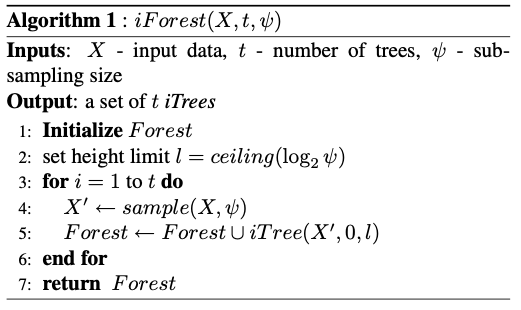

    1. ForestÏùÑ Ï†ÄÏû•Ìï† Îπà Í∞ùÏ≤¥ ÏÉùÏÑ±
    2. for loop
        3. Îç∞Ïù¥ÌÑ∞(X) ÏÉòÌîåÎßÅ
        4. ÏÉòÌîåÎßÅÎêú X‚Ä≤Î°ú ÎßåÎì§Ïñ¥ÏßÑ iTreeÎ•º Forest Í∞ùÏ≤¥Ïóê Ï∂îÍ∞Ä
    5. Ï¢ÖÎ£å
    6. Forest Í∞ùÏ≤¥ Î∞òÌôò

In [37]:
def isolation_forest(df, n_trees=5, max_depth=5, subspace=256):
    forest = []

    for i in range(n_trees):
        # Sample the subspace
        if subspace <= 1:
            df = df.sample(frac=subspace)
        else:
            df = df.sample(subspace)

        # Fit tree
        tree = isolation_tree(df, max_depth=max_depth)

        # Save tree to forest
        forest.append(tree)

    return forest

### Algorithm 3 (PathLength)

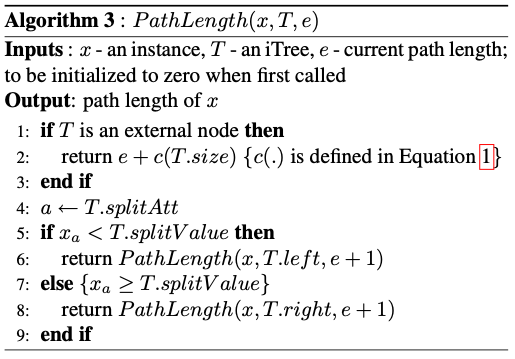

    1. Îç∞Ïù¥ÌÑ∞Ïùò ÏàòÍ∞Ä 1Î≥¥Îã§ ÌÅ¨Í≥† external node Ïù¥Í±∞ÎÇò hlimÎ≥¥Îã§ ÌÅ¥Îïå,
        2. Î∂ÑÍ∏∞ÌïòÏßÄ Î™ªÌïú Í≤ÉÏóê ÎåÄÌïú ÌèâÍ∑† height(c(n))Î•º ÎçîÌï¥ Ï§å
    4. splitÌïòÎ†§Îäî Î≥ÄÏàòÎ•º aÎ°ú Ï†ïÏùò
    5. Î≥ÄÏàò aÏùò Í∞íÏùÑ Í∞ÄÏ†∏ÏôÄ split pointÎ≥¥Îã§ ÏûëÏúºÎ©¥ ÎàÑÏ†ÅÎêú ÌòÑÏû¨ pathLengthÎ•º Î∞òÌôò
    6. Î≥ÄÏàò aÏùò Í∞íÏùÑ Í∞ÄÏ†∏ÏôÄ split pointÎ≥¥Îã§ ÌÅ¨Î©¥ ÎàÑÏ†ÅÎêú ÌòÑÏû¨ pathLengthÎ•º Î∞òÌôò

In [38]:
def pathLength(example, iTree, path=0, trace=False):

    path = path+1
    question = list(iTree.keys())[0]

    feature_name, comparison_operator, value = question.split()

    # ask question
    if example[feature_name].values <= float(value):
        answer = iTree[question][0]
    else:
        answer = iTree[question][1]

    # base case
    if not isinstance(answer, dict):
        return path

    # recursive part
    else:
        residual_tree = answer
        return pathLength(example, residual_tree, path=path)

    return path

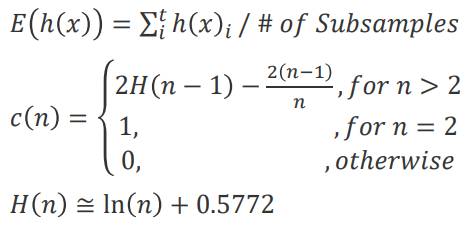

‚Ä¢ ‚Ñé(ùë•): ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ ùíôÍπåÏßÄÏùò Path length


‚Ä¢ ùê∏(‚Ñé(ùë•)): ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ ùë•Í∞Ä Í∞Å iTreeÏóêÏÑú Íµ¨Î∂ÑÎê† Îïå, ÏÇ¨Ïö©Îêú Path lengthsÏùò ÌèâÍ∑†


‚Ä¢ ùëê(ùëõ): ‚Ñé(ùë•)Î•º normalizeÌïòÍ∏∞ ÏúÑÌïú Í∞íÏúºÎ°ú, iTreeÏùò ÌèâÍ∑† Path length $(average~path~length~of~unsuccessful~search~in~BST~(Binary~Search~Tree)[B. R. Presis, 1999])$


‚Ä¢ ùëõ: the number of sample data


‚Ä¢ ùêª(ùëõ): Harmonic number (0.5772: Euler-Mascheroni Constant)

- ÏúÑÏùò Algorithm 3Î•º ÌÜµÌï¥ Î™®Îì† Îç∞Ïù¥ÌÑ∞ Ìè¨Ïù∏Ìä∏Ïùò path lengthÎ•º Íµ¨Ìï† Ïàò ÏûàÎã§.
- Ïù¥Î•º t Í∞úÏùò iTreeÏóê Ï†ÅÏö©Ìïú ÌõÑ average ÌïòÎ©¥ Î™®Îì† Îç∞Ïù¥ÌÑ∞ Ìè¨Ïù∏Ìä∏Ïóê ÎåÄÌï¥ average path length Ïù∏ $E(h(x))$Î•º ÏñªÏùÑ Ïàò ÏûàÎã§.
- Ïù¥Î•º Ïù¥Ïö©Ìï¥ ÏµúÏ¢ÖÏ†ÅÏúºÎ°ú Anomaly score Ïù∏ $s(x,n)$ÏùÑ ÏñªÎäîÎã§.

In [39]:
def harmonic_number(n, constant):
    return np.log(n)+constant

In [40]:
def c_factor(n, constant):
    if n > 2:
        return 2 * harmonic_number(n-1, constant) - 2*(n-1)/n
    if n == 2:
        return 1
    return 0

In [41]:
def evaluate_instance(instance, forest):
    paths = []
    for tree in forest:
        paths.append(pathLength(instance, tree))
    return paths

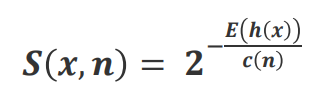

In [42]:
def anomaly_score(data_point, forest, n, constant):
    # Mean depth for an instance
    E = np.mean(evaluate_instance(data_point, forest))
    c = c_factor(n, constant)
    return 2**-(E/c)

#### Evaluate the whole dataset

In [43]:
iForest = isolation_forest(X, n_trees=20, max_depth=100, subspace=256)

- ÏûÑÏùòÏùò isolation forest Î∂ÑÎ•òÍ∏∞Î•º ÏÉùÏÑ± Î∞è ÏúÑÏùò ÏÉùÏÑ± Îç∞Ïù¥ÌÑ∞ÏÖã XÏóê ÎåÄÌï¥ Î∂ÑÌï†Í≥ºÏ†ïÏùÑ ÏßÑÌñâÌïúÎã§.

In [44]:
an= []
for i in range(X.shape[0]):
    an.append(anomaly_score(X.iloc[[i]],iForest,256, np.euler_gamma))

- Ìï¥Îãπ Î∂ÑÎ•òÍ∏∞Ïóê ÎåÄÌï¥ Î™®Îì† Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ ÎÑ£Í≥† Ïù¥ÏÉÅÏπò Ï†êÏàòÎ•º Í≥ÑÏÇ∞ÌïúÎã§.


- Ïù¥Îïå, average path length Í≥ÑÏÇ∞ÏùÑ ÏúÑÌï¥ÏÑú ÌïôÏäµÏóê ÏÇ¨Ïö©Îêú sampel_size $(n)$Îäî ÏúÑ Î∂ÑÎ•òÍ∏∞Ïùò ÏÑ§Ï†ïÏ≤òÎüº ÎèôÏùºÌïòÍ≤å Í∏∞Î≥∏ Í∞úÏàòÏù∏ 256Í∞úÎ°ú ÏÑ§Ï†ïÌñàÎã§.

In [45]:
def instance_depth_plot(instance,outlier,forest):
    plt.rcParams['figure.figsize'] = [20, 10]
    
    bars1 = evaluate_instance(outlier,forest)
    bars2 = evaluate_instance(instance,forest)

    # width of the bars
    barWidth = 0.3

    # The x position of bars
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]
    
    # Create cyan bars
    plt.bar(r2, bars2, width = barWidth, capsize=7, label='Normal Sample')

    # Create blue bars
    plt.bar(r1, bars1, width = barWidth,  capsize=7, label='Outlier')
    
    # general layout

    plt.ylabel('Tree Depth')
    plt.xlabel('Trees')
    plt.legend()

    plt.show()

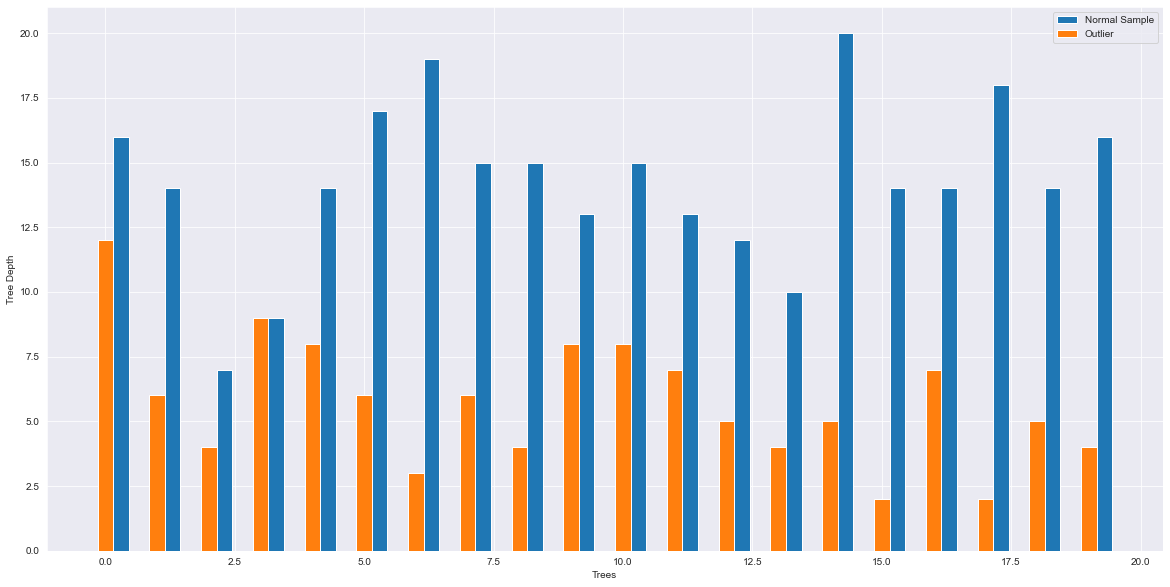

In [108]:
instance_depth_plot(X.head(1),X.tail(1),iForest)

- 1Í∞ú Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌï¥ ÌïôÏäµÏùÑ ÏúÑÌï¥ ÏÇ¨Ïö©ÎêòÏóàÎçò Í∞Å treeÎì§ (20Í∞ú)Ïóê ÎåÄÌï¥ Ïã§ÌóòÏùÑ Ìïú Î™®ÏäµÏûÖÎãàÎã§.




- Ï≤òÏùå X.tail(1)ÏùÄ Îç∞Ïù¥ÌÑ∞ÏÖãÏóêÏÑú Îí§ÏóêÏÑú 1Í∞úÎ•º ÏÑ†ÌÉùÌïòÎäî Í≤ÉÏù¥Í≥†, X.head(1)ÏùÄ ÏúÑÏóêÏÑú 1Í∞úÎ•º ÏÑ†ÌÉùÌïòÎäî Í≤ÉÏûÖÎãàÎã§.



    - ÏÉùÏÑ± Îç∞Ïù¥ÌÑ∞ÏÖãÏùò Í≤ΩÏö∞, Ï†ïÏÉÅ Îç∞Ïù¥ÌÑ∞Í∞Ä ÏúÑÏ™ΩÏúºÎ°ú, Ïù¥ÏÉÅ Îç∞Ïù¥ÌÑ∞Í∞Ä ÏïÑÎûòÏ™ΩÏù¥ ÎêòÎèÑÎ°ù Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ concatÌñàÏùåÏùÑ ÏÉùÍ∞ÅÌïòÍ≥† plotting Í≤∞Í≥ºÎ•º Î≥¥Î©¥ Îê† Í≤É Í∞ôÏäµÎãàÎã§.





- Ïã§ÌóòÍ≤∞Í≥º, Í∞Å treeÏóêÏÑú Ï†ïÏÉÅ Îç∞Ïù¥ÌÑ∞Ïùò tree depthÍ∞Ä Ïù¥ÏÉÅ Îç∞Ïù¥ÌÑ∞Î≥¥Îã§ Ìõ®Ïî¨ ÌÅ∞ Í≤ÉÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏäµÎãàÎã§.

In [109]:
outlier  = evaluate_instance(X.tail(1),iForest)
normal  = evaluate_instance(X.head(1),iForest)

In [110]:
np.mean(outlier)

5.75

In [111]:
np.mean(normal)

14.25

- tree ÍπäÏù¥Ïùò ÌèâÍ∑†Í∞íÏóê ÎåÄÌïú ÎπÑÍµê Í≤∞Í≥º, Ï†ïÏÉÅ Îç∞Ïù¥ÌÑ∞Ïùò Í≤ΩÏö∞ depth Í∞íÏù¥ ÌÅ¨Í≥† Ïù¥ÏÉÅ Îç∞Ïù¥ÌÑ∞Ïùò Í≤ΩÏö∞ Î≥¥Îã§ ÏûëÏùÄ depth Í∞íÏù¥ ÎÇòÏò§Îäî Í≤ÉÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏäµÎãàÎã§.

- Ïù¥Îäî Ï†ïÏÉÅ Îç∞Ïù¥ÌÑ∞Îäî Î∂ÑÎ•òÎ•º ÏúÑÌï¥ÏÑú ÎßéÏùÄ ÏàòÏùò Í∞ÄÏßÄÍ∞Ä ÌïÑÏöîÌïòÍ≥†, Ïù¥ÏÉÅ Îç∞Ïù¥ÌÑ∞Îäî Ï†ÅÏùÄ Í∞ÄÏßÄÍ∞Ä ÌïÑÏöîÌï®ÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏäµÎãàÎã§.

In [94]:
iForest = isolation_forest(X,n_trees=20, max_depth=100, subspace=256)

In [112]:
print('Anomaly score for outlier:',anomaly_score(X.tail(1),iForest,256, np.euler_gamma))

Anomaly score for outlier: 0.6777091054172627


In [97]:
print('Anomaly score for normal:',anomaly_score(X.head(1),iForest,256, np.euler_gamma))

Anomaly score for normal: 0.38131270251231675


- Ïù¥ÏÉÅÏπò Ï†êÏàòÏóê ÎåÄÌïú ÎπÑÍµê Í≤∞Í≥º, [0,1] Î≤îÏúÑ ÎÇ¥ÏóêÏÑú Î≥¥Î©¥ Ï†ïÏÉÅ Îç∞Ïù¥ÌÑ∞ÏÖãÏóê ÎåÄÌïú Í≤ΩÏö∞ Ï†êÏàòÍ∞Ä ÌôïÏó∞Ìûà ÎÇÆÍ≤å ÎÇòÏò¥ÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÍ≥†, Ïù¥ÏÉÅ Îç∞Ïù¥ÌÑ∞Ïùò Í≤ΩÏö∞ Í∞íÏù¥ ÌÅ¨Í≤å ÎÇòÌÉÄÎÇ®ÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏäµÎãàÎã§.

## Average path length - Euler constant

    - Ïù¥ ÌååÌä∏ÏóêÏÑúÎäî Average path length Í≥ÑÏÇ∞Ïóê ÏûàÏñ¥ÏÑú
    Ïôú ùêª(ùëõ): Harmonic number (0.5772: Euler-Mascheroni Constant)ÏùÑ ÏÇ¨Ïö©ÌïòÎäîÏßÄÏóê ÎåÄÌï¥ Í∂ÅÍ∏àÏ¶ùÏùÑ Ìï¥Í≤∞ÌïòÎ†§Í≥† Ìï©ÎãàÎã§.
    
    - ùêª(ùëõ): Harmonic number (0.5772: Euler-Mascheroni Constant)Ïóê ÎåÄÌï¥ÏÑúÎäî 'average path length of unsuccessful search in BST (Binary Search Tree)[B. R. Presis, 1999]'Ïùò ÎÇ¥Ïö©ÏùÑ ÏÇ¨Ïö©Ìïú Í≤ÉÏúºÎ°ú, ÏûêÎ£åÍµ¨Ï°∞Ïóê ÎåÄÌïú ÎÇ¥Ïö©Ïù¥ ÌïÑÏöîÌïòÎã§.
    
    - unsuccessful searchÎûÄÏóê ÎåÄÌï¥ ÏïåÎ†§Î©¥ Ïö∞ÏÑ† Ìï¥Ïâ¨ ÌÖåÏù¥Î∏îÏóê ÎåÄÌï¥ ÏïåÏïÑÏïº Ìï©ÎãàÎã§.
        - Ìï¥Ïã±: ÏûÑÏùòÏùò Í∏∏Ïù¥Ïùò Í∞íÏùÑ Ìï¥ÏãúÌï®Ïàò(Hash Function)Î•º ÏÇ¨Ïö©ÌïòÏó¨ Í≥†Ï†ïÎêú ÌÅ¨Í∏∞Ïùò Í∞íÏúºÎ°ú Î≥ÄÌôòÌïòÎäî ÏûëÏóÖ
        - Ìï¥Ïãú ÌÖåÏù¥Î∏î: Ìï¥ÏãúÌï®ÏàòÎ•º ÏÇ¨Ïö©ÌïòÏó¨ Î≥ÄÌôòÌïú Í∞íÏùÑ ÏÉâÏù∏(index)ÏúºÎ°ú ÏÇºÏïÑ ÌÇ§(key)ÏôÄ Îç∞Ïù¥ÌÑ∞(value)Î•º Ï†ÄÏû•ÌïòÎäî ÏûêÎ£åÍµ¨Ï°∞
        - successful search: Ï∞æÍ≥†Ïûê ÌïòÎäî Îç∞Ïù¥ÌÑ∞Í∞Ä Ìï¥Ïãú ÌÖåÏù¥Î∏îÏóê ÏûàÎäî Í≤ΩÏö∞
        - unsuccessful search: Ï∞æÍ≥†Ïûê ÌïòÎäî Îç∞Ïù¥ÌÑ∞Í∞Ä Ìï¥Ïãú ÌÖåÏù¥Î∏îÏóê ÏóÜÎäî Í≤ΩÏö∞
    
    - Îî∞ÎùºÏÑú, BSTÎ•º Ïù¥Ïö©Ìï¥ ÏûêÎ£åÎ•º Î∂ÑÌï†ÌïòÍ≥† ÌÉêÏÉâÌïòÎäî Í≥ºÏ†ïÏóêÏÑú, ÏïåÍ≥†Ïã∂ÏùÄ Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌï¥ Ìï¥Ïãú ÌÖåÏù¥Î∏îÏùÑ Íµ¨ÏÑ±ÌïòÏßÄ Î™ªÌïú ÏÉÅÌô©ÏóêÏÑú
    'ÌèâÍ∑†Ï†ÅÏúºÎ°ú Ïñ¥ÎäêÏ†ïÎèÑÏùò path lengthÎ•º Í∞ÄÏßÄÍ≤†Íµ¨ÎÇò'ÎùºÎäî Í∏∞ÎåÄÍ∞íÏùÑ ÏñòÍ∏∞ÌïòÎäî Í≤ÉÏûÖÎãàÎã§.
    
    Ìï¥Îãπ Í≥ºÏ†ïÏùÑ Ïú†ÎèÑÌïòÎäî Í≥ºÏ†ïÏùÄ Îã§Ïùå Í≥ºÏ†ïÏùÑ Í±∞Ï≥êÏÑú Í≤∞Î°†Ï†ÅÏúºÎ°ú Ïò§ÏùºÎü¨ ÏÉÅÏàòÍ∞Ä ÎÇòÏò§Îäî Ïù¥Ïú†Í∞Ä ÏÑ§Î™ÖÎê©ÎãàÎã§.
Ref)
https://en.wikipedia.org/wiki/Harmonic_number

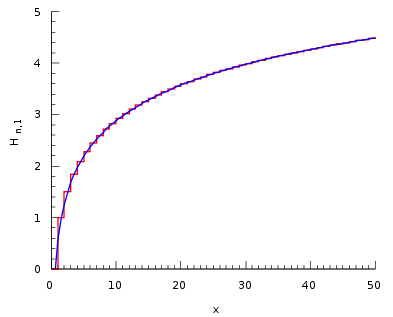

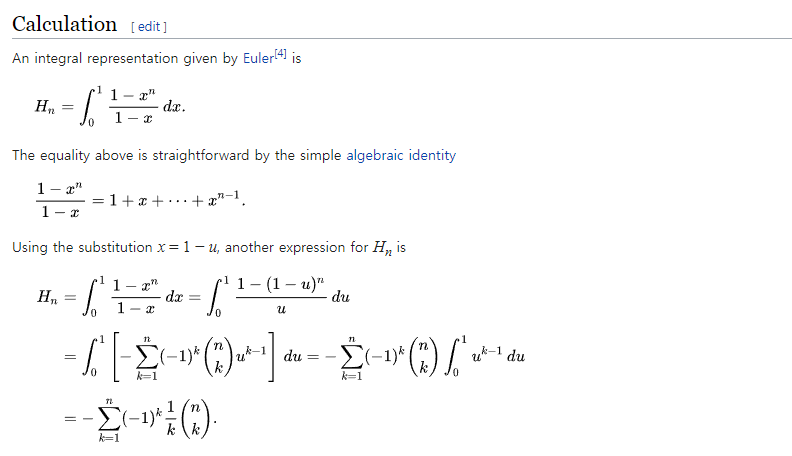

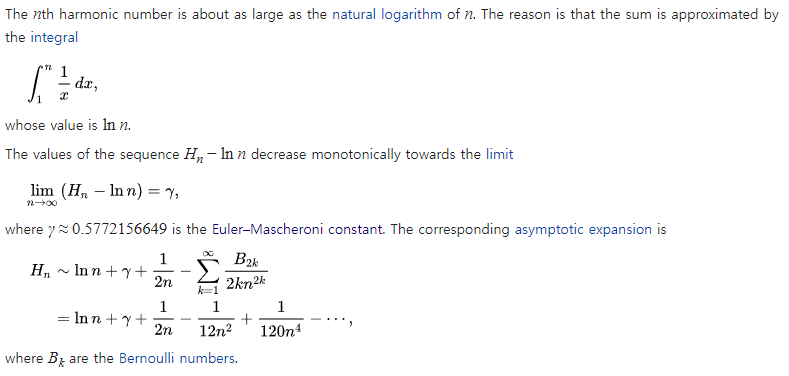

    - ÏÇ¨Ïã§ ÏàòÌïôÏ†Å Í≥ÑÏÇ∞ÏóêÏùòÌï¥ ÎèÑÏ∂úÎêú Í∞íÏùÑ ÏÇ¨Ïö©ÌïòÎäî Í≤ÉÏù¥ÎØÄÎ°ú, Ìï¥Îãπ ÏàòÏãùÏùÑ Î≥ÄÍ≤ΩÌïòÍ±∞ÎÇò Îã§Î•∏ Í∞íÏúºÎ°ú ÏÇ¨Ïö©ÌïòÍ≤å ÎêòÎ©¥ Í≤∞Î°†Ï†ÅÏúºÎ°úÎäî Ïù¥ÏÉÅÏπò Ïä§ÏΩîÏñ¥ Î≥ÄÌòïÏóê ÏûàÏñ¥ÏÑú Í∏∞Ï°¥Ïùò [0,1] ÏÇ¨Ïù¥Ïùò Í∞íÏù¥ ÏïÑÎãå Îçî ÎÑìÏùÄ Î≤îÏúÑÏùò Í∞íÏù¥ ÎÇòÏò§Í≤å Îê† Í∞ÄÎä•ÏÑ±ÎèÑ Ï°¥Ïû¨ÌïòÍ≤å Îê©ÎãàÎã§.

    - ÌïòÏßÄÎßå Í∞úÏù∏Ï†ÅÏù∏ ÏùòÎ¨∏ÏúºÎ°ú, Ïò§ÏùºÎü¨ ÏÉÅÏàò Ïù¥Ïô∏Ïùò Îã§Î•∏ Í∞íÏùÑ ÎÑ£Ïñ¥Î≥¥Î©¥ Ïñ¥ÎñªÍ≤å Î≥ÄÌôîÎêòÎäîÏßÄÎ•º Í∞ÄÎ≥çÍ≤å ÏïåÏïÑÎ≥¥Í≥†Ïûê Ìï©ÎãàÎã§.
        - Ïó¨Í∏∞ÏÑú ÎÇòÎäî Ïò§ÏùºÎü¨ ÏÉÅÏàòÎ•º ÏßÄÏö¥ Î≤ÑÏ†ÑÍ≥º Ïò§ÏùºÎü¨ ÏÉÅÏàòÏôÄ Í¥ÄÎ†®ÏûàÎäî Gamma functionÍ≥º Í¥ÄÎ†®Îêú Îã§ÏñëÌïú ÏàòÌïôÏ†Å ÏÉÅÏàòÎì§ÏùÑ Ï†ÅÏö©Ìï¥Î≥¥Í≥† Ï∂úÎ†•ÎêòÎäî Í≤∞Í≥ºÍ∞íÎì§Ïóê ÎåÄÌïú ÎπÑÍµêÎ•º Î≥¥Ïó¨Ï£ºÍ≥†Ïûê Ìï©ÎãàÎã§.

- Ï∞®Î°ÄÎåÄÎ°ú [Zero, Euler_constant, Bernstein_constant, Ap√©ry's constant, Sierpi≈Ñski constant, Gauss's constant, Landau's constants]

In [53]:
constants_dict = {'zero':0, 'Euler_constant':np.euler_gamma, 'Bernstein_constant':0.2801694990, 'Ap√©ry constant':1.2020569032, 'Sierpi≈Ñski constant':2.5849817596, 'Gauss constant':0.8346268, 'Landau constants':0.5432589653}

In [54]:
iForest = isolation_forest(X, n_trees=100, max_depth=100, subspace=256)

In [113]:
for i, constant in constants_dict.items():
    print(f'Anomaly score for outlier with: {i}')
    print(anomaly_score(X.tail(1), iForest, 256, constant))
    print(f'Anomaly score for normal with: {i}')
    print(anomaly_score(X.head(1), iForest, 256, constant))
    print('\n')

Anomaly score for outlier with: zero
0.6450399294373197
Anomaly score for normal with: zero
0.3373695795995949


Anomaly score for outlier with: Euler_constant
0.6777091054172627
Anomaly score for normal with: Euler_constant
0.38131270251231675


Anomaly score for outlier with: Bernstein_constant
0.6616714679526894
Anomaly score for normal with: Bernstein_constant
0.3593396144499707


Anomaly score for outlier with: Ap√©ry constant
0.7069885361463043
Anomaly score for normal with: Ap√©ry constant
0.4234523754315913


Anomaly score for outlier with: Sierpi≈Ñski constant
0.7561701287615084
Anomaly score for normal with: Sierpi≈Ñski constant
0.5002504631145861


Anomaly score for outlier with: Gauss constant
0.6904425005751865
Anomaly score for normal with: Gauss constant
0.3993153634986354


Anomaly score for outlier with: Landau constants
0.6759519405155894
Anomaly score for normal with: Landau constants
0.3788672189482939




- Ïã§Ìóò Í≤∞Í≥º, Ïù¥ÏÉÅÏπò Ï†êÏàòÎ•º ÎÇòÌÉÄÎÉÑÏóê ÏûàÏñ¥ Ï†úÍ≥± Î∂ÄÎ∂ÑÏùò Î∂ÑÎ™® Î∂ÄÎ∂ÑÏùò Í∞íÏù¥ Î≥ÄÌôîÎê®Ïóê Îî∞Îùº ÏûêÏó∞Ïä§ÎüΩÍ≤å Ïù¥ÏÉÅÏπò Ï†êÏàòÏùò Î≤îÏúÑÍ∞Ä Î≥ÄÎèôÏù¥ Îê† Í≤ÉÏûÖÎãàÎã§.


- Ïö∞ÏÑ† Î™®Îì† ÏºÄÏù¥Ïä§Ïóê ÎåÄÌï¥ Ï†ïÏÉÅ Îç∞Ïù¥ÌÑ∞Ïùò Ïù¥ÏÉÅÏπò Ï†êÏàòÍ∞Ä Ïù¥ÏÉÅ Îç∞Ïù¥ÌÑ∞Ïùò Ïù¥ÏÉÅÏπò Ï†êÏàòÎ≥¥Îã§ ÎÇÆÍ≤å ÎÇòÏôîÏùåÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏóàÏäµÎãàÎã§.

- ÌïòÏßÄÎßå, Í≥µÎ∂ÄÎ•º Ìï† ÏàòÎ°ù Ï¶ùÎ™ÖÏóê ÏùòÌï¥ Í≥ÑÏÇ∞Îêú Ïò§ÏùºÎü¨ ÏÉÅÏàòÎ•º ÏÇ¨Ïö©ÌïòÎäî Í≤ÉÏù¥ ÎßûÎã§ÎùºÍ≥† ÏÉùÍ∞ÅÌïòÍ≤å ÎêòÏóàÎäîÎç∞ ÏôúÎÇòÌïòÎ©¥ Î∂àÏôÑÏ†ÑÌïú Ïù¥ÏßÑ ÌÉêÏÉâ Ìä∏Î¶¨ Íµ¨Ï°∞ÏóêÏÑú Í≤∞Íµ≠ ÌèâÍ∑†Ï†ÅÏúºÎ°ú Í≥ÑÏÇ∞ÎêòÎäî Í≤ΩÎ°ú Í∏∏Ïù¥Îäî Í≤∞Íµ≠ Ï°∞ÌôîÏàòÏùò Í∞íÏùÑ Îî∞ÎùºÍ∞ÄÎäî Í≤ÉÏùÑ ÌôïÏù∏ÌñàÍ∏∞ ÎïåÎ¨∏ÏûÖÎãàÎã§. (ÏúÑÏùò ÏÑ§Î™Ö Í∑∏Î¶º Ï∞∏Í≥†)


- Îî∞ÎùºÏÑú, Ïò§ÏùºÎü¨ ÏÉÅÏàòÎ•º Ïù¥Ïö©Ìï¥ÏÑú Í≥ÑÏÇ∞ÌïòÎäî Í≤ÉÏù¥ Ïù¥ÏÉÅÏπò Ï†êÏàò Í≥ÑÏÇ∞ Î∂ÄÎ∂ÑÏóê ÏûàÏñ¥ $E(h(n))$ÏùÑ normalizeÌïòÎäî Ïó≠Ìï†ÏùÑ Ïûò Ìï¥Ï£ºÎäî Í≤ÉÏúºÎ°ú ÏÉùÍ∞ÅÎêòÍ∏∞ ÎïåÎ¨∏Ïóê Ïò§ÏùºÎü¨ ÏÉÅÏàòÎ•º ÏÇ¨Ïö©ÌïòÎäî Í≤ÉÏóê ÎåÄÌïú Í∂ÅÍ∏àÏ¶ùÏùÑ Ìï¥Í≤∞Ìï† Ïàò ÏûàÏóàÏäµÎãàÎã§.

# Referrence

https://scikit-learn.org/stable/auto_examples/ensemble/plot_isolation_forest.html#sphx-glr-auto-examples-ensemble-plot-isolation-forest-py
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html
https://donghwa-kim.github.io/iforest.html
https://github.com/cmougan/IsolationForest/blob/master/IsolationForest.ipynb

# EOD